In [13]:
# import packages & variables
import argparse
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoModelForSequenceClassification
import json
import os
import time
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

# Parameters
model_name = 'meta-llama/Meta-Llama-3.1-8B'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_30.non_infringement.json'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_30.infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_0_layer.pth'


In [14]:
# Define CustumMLP for internal states train
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomMLP, self).__init__()
        self.down = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Linear(input_dim, hidden_dim)
        self.up = nn.Linear(hidden_dim, 1)
        self.activation = nn.SiLU()

    def forward(self, x):
        down_output = self.down(x)
        gate_output = self.gate(x)
        gated_output = down_output * self.activation(gate_output)
        return self.up(gated_output)

In [15]:
# Extract hidden states/reference embeddings
def extract_hidden_states(texts, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    hidden_states = []
    
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing data batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True).to(device)
        
        with torch.no_grad():
            outputs = model(**inputs)
        hidden_states.append(outputs.hidden_states[-1].mean(dim=1).cpu().numpy())
    
    return np.vstack(hidden_states)


# Extract decoding results and last token hidden states
def extract_decoding(references, model, tokenizer, max_length=300, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    outputs = []
    ttft_list = []
    tpot_list = []
    sysprompt = "You will be shown a series of passages from famous literary works. After these examples, you will receive a prefix from another passage and be asked to complete it based on the text of a famous work. Provide only the continuation for the last given prefix without any extra commentary, formatting, or additional text."
    for i in tqdm(range(0, len(references), batch_size), desc="Processing references"):
        batch_references = references[i:i + batch_size]
        batch_references = [sysprompt + " " + ref for ref in batch_references]
        # print(batch_references)
        inputs = tokenizer(batch_references, return_tensors="pt", padding=True, truncation=True, padding_side='left').to(device)
        tokenizer.pad_token_id = tokenizer.eos_token_id
        
        with torch.no_grad():
            # Generate sequences
            start_time = time.time()  # Start time for TTFT
            generated_ids = model.generate(**inputs, max_new_tokens=10, output_hidden_states=True, return_dict_in_generate=True, use_cache=True)
            
            # print(generated_ids["hidden_states"])
            
            ttft = time.time() - start_time  # Calculate TTFT
            
            # Calculate TPOT
            num_tokens_generated = generated_ids["sequences"].shape[1]  # Number of tokens generated
            tpot = ttft / num_tokens_generated if num_tokens_generated > 0 else float('inf')
            # print(len(generated_ids["hidden_states"][0][0]))
            # print(len(generated_ids["hidden_states"][0]))
            # print(len(generated_ids["hidden_states"]))
            last_token_hidden_state = generated_ids["hidden_states"][-1][-1].mean(dim=1).cpu().numpy()
        
        outputs.append(last_token_hidden_state)
        ttft_list.append(ttft)
        tpot_list.append(tpot)
        
            # 在处理完所有批次后，计算ttft_list的平均值
        average_ttft = np.mean(ttft_list)
        average_tpot = np.mean(tpot_list)
        # Debugging: Check shapes
        # print("Last token hidden state shape:", last_token_hidden_state.shape)
    
    # print("np.vstack(outputs).shape:", np.vstack(outputs).shape)
    return np.vstack(outputs), average_ttft, average_tpot

In [16]:
# load data for infringement & non infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    non_infringement_references = [entry['reference'] for entry in non_infringement_json_data]
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    infringement_references = [entry['reference'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement

In [17]:
from sklearn.metrics import accuracy_score, classification_report, f1_score

# Train for best model
def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=2000, lr=0.001, checkpoint_path=checkpoint_file):
    custom_mlp = CustomMLP(input_dim, hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    best_accuracy = -float('inf')
    best_f1 = -float('inf')  # Track best F1-score
    best_model_state = None
    best_epoch = 0
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        # Every 10 epochs, evaluate the model
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().numpy()
            
            # Calculate accuracy and F1-score
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)  # F1-score calculation
            
            print(f"Test Accuracy at Epoch {epoch + 1}: {accuracy * 100:.2f}%")
            print(f"Test F1-score at Epoch {epoch + 1}: {f1:.4f}")
            
            # Generate classification report
            report = classification_report(y_test, y_pred, target_names=["infringement", "non_infringement"])
            print(f"Classification Report at Epoch {epoch + 1}:\n{report}")

            # Save the model if it achieves a better F1-score
            if f1 > best_f1:
                best_accuracy = accuracy
                best_f1 = f1
                best_model_state = custom_mlp.state_dict()
                best_epoch = epoch + 1
                torch.save(best_model_state, checkpoint_path)
                print(f"New best model saved with F1-score {best_f1:.4f} at epoch {best_epoch}")
                print(f"Best Classification Report at Epoch {best_epoch}:\n{report}")

    # Load the best model state
    custom_mlp.load_state_dict(torch.load(checkpoint_path))

    # Plot loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
    print(f"Final Model F1-score: {best_f1:.4f}")
    
    return custom_mlp, losses, best_accuracy, best_f1


In [18]:
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer.pad_token = tokenizer.eos_token
bert_tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')
bert_model = AutoModel.from_pretrained('google-bert/bert-base-uncased')
bert_tokenizer.pad_token = tokenizer.eos_token

non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement = load_data(
    non_infringement_file, infringement_file
)

y_non_infringement = np.array(y_non_infringement)
y_infringement = np.array(y_infringement)


/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:774: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:03<00:00,  1.21it/s]


In [ ]:
# print("Extracting hidden states for non_infringement texts...")
# X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)
# print("Extracting reference embeddings for non_infringement texts...")
# reference_embeddings_non_infringement = extract_reference_embeddings(non_infringement_references, bert_model, bert_tokenizer)
# X_non_infringement_combined = np.hstack([X_non_infringement, reference_embeddings_non_infringement])

# print("Extracting hidden states for infringement texts...")
# X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)
# print("Extracting reference embeddings for infringement texts...")
# reference_embeddings_infringement = extract_reference_embeddings(infringement_references, bert_model, bert_tokenizer)
# X_infringement_combined = np.hstack([X_infringement, reference_embeddings_infringement])


# 在主程序中
print("Extracting hidden states for non_infringement texts...")
X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)
print("Extracting decoding for non_infringement texts...")
last_token_hidden_states_non_infringement, totaltime_non_infringement, tpot_non_infringement = extract_decoding(non_infringement_outputs, model, tokenizer)

if (X_non_infringement.shape[0]!=last_token_hidden_states_non_infringement.shape[0]):
    print("X_non_infringement.shape[0]:", X_non_infringement.shape[0])
    print("last_token_hidden_states_non_infringement.shape[0]:", last_token_hidden_states_non_infringement.shape[0])
    # 对齐两个数组的行数
    min_rows = min(X_non_infringement.shape[0], last_token_hidden_states_non_infringement.shape[0])

    # 裁剪两个数组到相同的行数
    X_non_infringement_aligned = X_non_infringement[:min_rows, :]
    last_token_hidden_states_non_infringement_aligned = last_token_hidden_states_non_infringement[:min_rows, :]
else:
    X_non_infringement_aligned = X_non_infringement
    last_token_hidden_states_non_infringement_aligned = last_token_hidden_states_non_infringement

    # 进行合并
X_non_infringement_combined = np.hstack([X_non_infringement_aligned, last_token_hidden_states_non_infringement_aligned])



print("Extracting hidden states for infringement texts...")
X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)
print("Extracting decoding for infringement texts...")
last_token_hidden_states_infringement, totaltime_infringement, tpot_infringement = extract_decoding(infringement_outputs, model, tokenizer)

if (X_infringement.shape[0]!=last_token_hidden_states_infringement.shape[0]):
    print("X_infringement.shape[0]:", X_infringement.shape[0])
    print("last_token_hidden_states_non_infringement.shape[0]:", last_token_hidden_states_infringement.shape[0])
    # 对齐两个数组的行数
    min_rows = min(X_infringement.shape[0], last_token_hidden_states_infringement.shape[0])

    # 裁剪两个数组到相同的行数
    X_infringement_aligned = X_infringement[:min_rows, :]
    last_token_hidden_states_infringement_aligned = last_token_hidden_states_infringement[:min_rows, :]
else:
    X_infringement_aligned = X_infringement
    last_token_hidden_states_infringement_aligned = last_token_hidden_states_infringement

    # 进行合并
X_infringement_combined = np.hstack([X_infringement_aligned, last_token_hidden_states_infringement_aligned])

# 计算平均值
average_totaltime = (totaltime_non_infringement + totaltime_infringement) / 2
print("Average Total Time:", average_totaltime)
average_tpot = (tpot_non_infringement + tpot_infringement) / 2
print("Average Tpot:", average_tpot)

Extracting hidden states for non_infringement texts...


Processing data batches: 100%|██████████| 232/232 [01:01<00:00,  3.79it/s]


Extracting decoding for non_infringement texts...


Processing references:   0%|          | 0/232 [00:00<?, ?it/s]


TypeError: The current model class (BertModel) is not compatible with `.generate()`, as it doesn't have a language model head. Classes that support generation often end in one of these names: ['ForCausalLM', 'ForConditionalGeneration', 'ForSpeechSeq2Seq', 'ForVision2Seq'].

: 

In [ ]:
split_index_non_infringement = int(0.8 * len(X_non_infringement_combined))
X_non_infringement_train = X_non_infringement_combined[:split_index_non_infringement]
X_non_infringement_test = X_non_infringement_combined[split_index_non_infringement:]
y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

split_index_infringement = int(0.8 * len(X_infringement_combined))
X_infringement_train = X_infringement_combined[:split_index_infringement]
X_infringement_test = X_infringement_combined[split_index_infringement:]
y_infringement_train = y_infringement[:split_index_infringement]
y_infringement_test = y_infringement[split_index_infringement:]

X_train = np.vstack((X_non_infringement_train, X_infringement_train))
X_test = np.vstack((X_non_infringement_test, X_infringement_test))
y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

print("Data successfully split into training and test sets.")

Data successfully split into training and test sets.


Training MLP model with input_dim=8192 and hidden_dim=256


Training Epochs:   1%|          | 12/2000 [00:00<01:54, 17.29it/s]

Epoch 10/2000, Loss: 0.3119
Test Accuracy at Epoch 10: 59.21%
Test F1-score at Epoch 10: 0.5507
Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.59      0.67      0.63       194
non_infringement       0.60      0.51      0.55       186

        accuracy                           0.59       380
       macro avg       0.59      0.59      0.59       380
    weighted avg       0.59      0.59      0.59       380

New best model saved with F1-score 0.5507 at epoch 10
Best Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.59      0.67      0.63       194
non_infringement       0.60      0.51      0.55       186

        accuracy                           0.59       380
       macro avg       0.59      0.59      0.59       380
    weighted avg       0.59      0.59      0.59       380



Training Epochs:   1%|          | 22/2000 [00:01<02:07, 15.56it/s]

Epoch 20/2000, Loss: 0.1168
Test Accuracy at Epoch 20: 68.68%
Test F1-score at Epoch 20: 0.7119
Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.75      0.59      0.66       194
non_infringement       0.65      0.79      0.71       186

        accuracy                           0.69       380
       macro avg       0.70      0.69      0.68       380
    weighted avg       0.70      0.69      0.68       380

New best model saved with F1-score 0.7119 at epoch 20
Best Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.75      0.59      0.66       194
non_infringement       0.65      0.79      0.71       186

        accuracy                           0.69       380
       macro avg       0.70      0.69      0.68       380
    weighted avg       0.70      0.69      0.68       380



Training Epochs:   2%|▏         | 31/2000 [00:01<01:58, 16.58it/s]

Epoch 30/2000, Loss: 0.0377
Test Accuracy at Epoch 30: 68.95%
Test F1-score at Epoch 30: 0.6990
Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.72      0.64      0.68       194
non_infringement       0.67      0.74      0.70       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.69      0.69      0.69       380



Training Epochs:   2%|▏         | 43/2000 [00:02<01:55, 16.93it/s]

Epoch 40/2000, Loss: 0.0265
Test Accuracy at Epoch 40: 68.68%
Test F1-score at Epoch 40: 0.7090
Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.74      0.60      0.66       194
non_infringement       0.65      0.78      0.71       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.70      0.69      0.68       380



Training Epochs:   3%|▎         | 53/2000 [00:03<01:46, 18.31it/s]

Epoch 50/2000, Loss: 0.0234
Test Accuracy at Epoch 50: 68.68%
Test F1-score at Epoch 50: 0.7076
Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.74      0.60      0.66       194
non_infringement       0.65      0.77      0.71       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.69      0.69      0.68       380



Training Epochs:   3%|▎         | 61/2000 [00:03<02:14, 14.45it/s]

Epoch 60/2000, Loss: 0.0207
Test Accuracy at Epoch 60: 69.21%
Test F1-score at Epoch 60: 0.7139
Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.75      0.60      0.67       194
non_infringement       0.65      0.78      0.71       186

        accuracy                           0.69       380
       macro avg       0.70      0.69      0.69       380
    weighted avg       0.70      0.69      0.69       380

New best model saved with F1-score 0.7139 at epoch 60
Best Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.75      0.60      0.67       194
non_infringement       0.65      0.78      0.71       186

        accuracy                           0.69       380
       macro avg       0.70      0.69      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:   4%|▎         | 73/2000 [00:04<01:41, 18.99it/s]

Epoch 70/2000, Loss: 0.0194
Test Accuracy at Epoch 70: 68.16%
Test F1-score at Epoch 70: 0.7070
Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.74      0.58      0.65       194
non_infringement       0.64      0.78      0.71       186

        accuracy                           0.68       380
       macro avg       0.69      0.68      0.68       380
    weighted avg       0.69      0.68      0.68       380



Training Epochs:   4%|▍         | 82/2000 [00:04<01:48, 17.68it/s]

Epoch 80/2000, Loss: 0.0185
Test Accuracy at Epoch 80: 68.16%
Test F1-score at Epoch 80: 0.7056
Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.74      0.59      0.65       194
non_infringement       0.64      0.78      0.71       186

        accuracy                           0.68       380
       macro avg       0.69      0.68      0.68       380
    weighted avg       0.69      0.68      0.68       380



Training Epochs:   5%|▍         | 94/2000 [00:05<01:36, 19.74it/s]

Epoch 90/2000, Loss: 0.0188
Test Accuracy at Epoch 90: 67.63%
Test F1-score at Epoch 90: 0.7022
Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.73      0.58      0.65       194
non_infringement       0.64      0.78      0.70       186

        accuracy                           0.68       380
       macro avg       0.69      0.68      0.67       380
    weighted avg       0.69      0.68      0.67       380



Training Epochs:   5%|▌         | 101/2000 [00:05<01:52, 16.90it/s]

Epoch 100/2000, Loss: 0.0186
Test Accuracy at Epoch 100: 67.89%
Test F1-score at Epoch 100: 0.7039
Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.73      0.58      0.65       194
non_infringement       0.64      0.78      0.70       186

        accuracy                           0.68       380
       macro avg       0.69      0.68      0.68       380
    weighted avg       0.69      0.68      0.68       380



Training Epochs:   6%|▌         | 111/2000 [00:06<01:55, 16.29it/s]

Epoch 110/2000, Loss: 0.0177
Test Accuracy at Epoch 110: 67.37%
Test F1-score at Epoch 110: 0.7005
Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.73      0.57      0.64       194
non_infringement       0.64      0.78      0.70       186

        accuracy                           0.67       380
       macro avg       0.68      0.68      0.67       380
    weighted avg       0.68      0.67      0.67       380



Training Epochs:   6%|▌         | 122/2000 [00:07<01:56, 16.14it/s]

Epoch 120/2000, Loss: 0.0172
Test Accuracy at Epoch 120: 68.95%
Test F1-score at Epoch 120: 0.7136
Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.75      0.59      0.66       194
non_infringement       0.65      0.79      0.71       186

        accuracy                           0.69       380
       macro avg       0.70      0.69      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:   7%|▋         | 133/2000 [00:07<01:46, 17.48it/s]

Epoch 130/2000, Loss: 0.0170
Test Accuracy at Epoch 130: 69.47%
Test F1-score at Epoch 130: 0.7171
Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.75      0.60      0.67       194
non_infringement       0.66      0.79      0.72       186

        accuracy                           0.69       380
       macro avg       0.70      0.70      0.69       380
    weighted avg       0.70      0.69      0.69       380

New best model saved with F1-score 0.7171 at epoch 130
Best Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.75      0.60      0.67       194
non_infringement       0.66      0.79      0.72       186

        accuracy                           0.69       380
       macro avg       0.70      0.70      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:   7%|▋         | 140/2000 [00:08<01:52, 16.49it/s]

Epoch 140/2000, Loss: 0.0171
Test Accuracy at Epoch 140: 70.26%
Test F1-score at Epoch 140: 0.7224
Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.75      0.62      0.68       194
non_infringement       0.67      0.79      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380

New best model saved with F1-score 0.7224 at epoch 140
Best Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.75      0.62      0.68       194
non_infringement       0.67      0.79      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:   8%|▊         | 152/2000 [00:08<01:49, 16.89it/s]

Epoch 150/2000, Loss: 0.0170
Test Accuracy at Epoch 150: 70.00%
Test F1-score at Epoch 150: 0.7220
Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.76      0.61      0.67       194
non_infringement       0.66      0.80      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:   8%|▊         | 162/2000 [00:09<01:44, 17.67it/s]

Epoch 160/2000, Loss: 0.0176
Test Accuracy at Epoch 160: 68.16%
Test F1-score at Epoch 160: 0.7084
Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.74      0.58      0.65       194
non_infringement       0.64      0.79      0.71       186

        accuracy                           0.68       380
       macro avg       0.69      0.68      0.68       380
    weighted avg       0.69      0.68      0.68       380



Training Epochs:   9%|▊         | 173/2000 [00:10<01:47, 17.02it/s]

Epoch 170/2000, Loss: 0.0218
Test Accuracy at Epoch 170: 69.21%
Test F1-score at Epoch 170: 0.7082
Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.73      0.62      0.67       194
non_infringement       0.66      0.76      0.71       186

        accuracy                           0.69       380
       macro avg       0.70      0.69      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:   9%|▉         | 181/2000 [00:10<01:46, 17.05it/s]

Epoch 180/2000, Loss: 0.0191
Test Accuracy at Epoch 180: 68.68%
Test F1-score at Epoch 180: 0.7090
Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.74      0.60      0.66       194
non_infringement       0.65      0.78      0.71       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.70      0.69      0.68       380



Training Epochs:  10%|▉         | 191/2000 [00:11<01:39, 18.10it/s]

Epoch 190/2000, Loss: 0.0184
Test Accuracy at Epoch 190: 67.89%
Test F1-score at Epoch 190: 0.7039
Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.73      0.58      0.65       194
non_infringement       0.64      0.78      0.70       186

        accuracy                           0.68       380
       macro avg       0.69      0.68      0.68       380
    weighted avg       0.69      0.68      0.68       380



Training Epochs:  10%|█         | 203/2000 [00:11<01:32, 19.52it/s]

Epoch 200/2000, Loss: 0.0176
Test Accuracy at Epoch 200: 68.42%
Test F1-score at Epoch 200: 0.7101
Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.74      0.58      0.65       194
non_infringement       0.64      0.79      0.71       186

        accuracy                           0.68       380
       macro avg       0.69      0.69      0.68       380
    weighted avg       0.70      0.68      0.68       380



Training Epochs:  11%|█         | 212/2000 [00:12<01:29, 19.99it/s]

Epoch 210/2000, Loss: 0.0173
Test Accuracy at Epoch 210: 69.47%
Test F1-score at Epoch 210: 0.7184
Classification Report at Epoch 210:
                  precision    recall  f1-score   support

    infringement       0.75      0.60      0.67       194
non_infringement       0.65      0.80      0.72       186

        accuracy                           0.69       380
       macro avg       0.70      0.70      0.69       380
    weighted avg       0.71      0.69      0.69       380



Training Epochs:  11%|█         | 224/2000 [00:12<01:24, 21.06it/s]

Epoch 220/2000, Loss: 0.0171
Test Accuracy at Epoch 220: 69.21%
Test F1-score at Epoch 220: 0.7167
Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.75      0.59      0.66       194
non_infringement       0.65      0.80      0.72       186

        accuracy                           0.69       380
       macro avg       0.70      0.69      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  12%|█▏        | 232/2000 [00:13<01:42, 17.25it/s]

Epoch 230/2000, Loss: 0.0171
Test Accuracy at Epoch 230: 69.74%
Test F1-score at Epoch 230: 0.7202
Classification Report at Epoch 230:
                  precision    recall  f1-score   support

    infringement       0.75      0.60      0.67       194
non_infringement       0.66      0.80      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.69       380



Training Epochs:  12%|█▏        | 243/2000 [00:13<01:32, 19.01it/s]

Epoch 240/2000, Loss: 0.0169
Test Accuracy at Epoch 240: 68.68%
Test F1-score at Epoch 240: 0.7133
Classification Report at Epoch 240:
                  precision    recall  f1-score   support

    infringement       0.75      0.58      0.66       194
non_infringement       0.65      0.80      0.71       186

        accuracy                           0.69       380
       macro avg       0.70      0.69      0.68       380
    weighted avg       0.70      0.69      0.68       380



Training Epochs:  13%|█▎        | 254/2000 [00:14<01:26, 20.21it/s]

Epoch 250/2000, Loss: 0.0168
Test Accuracy at Epoch 250: 68.68%
Test F1-score at Epoch 250: 0.7133
Classification Report at Epoch 250:
                  precision    recall  f1-score   support

    infringement       0.75      0.58      0.66       194
non_infringement       0.65      0.80      0.71       186

        accuracy                           0.69       380
       macro avg       0.70      0.69      0.68       380
    weighted avg       0.70      0.69      0.68       380



Training Epochs:  13%|█▎        | 263/2000 [00:14<01:21, 21.34it/s]

Epoch 260/2000, Loss: 0.0172
Test Accuracy at Epoch 260: 68.16%
Test F1-score at Epoch 260: 0.7098
Classification Report at Epoch 260:
                  precision    recall  f1-score   support

    infringement       0.74      0.57      0.65       194
non_infringement       0.64      0.80      0.71       186

        accuracy                           0.68       380
       macro avg       0.69      0.68      0.68       380
    weighted avg       0.69      0.68      0.68       380



Training Epochs:  14%|█▎        | 272/2000 [00:15<01:36, 17.85it/s]

Epoch 270/2000, Loss: 0.0168
Test Accuracy at Epoch 270: 70.26%
Test F1-score at Epoch 270: 0.7237
Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.76      0.61      0.68       194
non_infringement       0.66      0.80      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380

New best model saved with F1-score 0.7237 at epoch 270
Best Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.76      0.61      0.68       194
non_infringement       0.66      0.80      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  14%|█▍        | 284/2000 [00:15<01:22, 20.78it/s]

Epoch 280/2000, Loss: 0.0167
Test Accuracy at Epoch 280: 69.21%
Test F1-score at Epoch 280: 0.7167
Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.75      0.59      0.66       194
non_infringement       0.65      0.80      0.72       186

        accuracy                           0.69       380
       macro avg       0.70      0.69      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  15%|█▍        | 293/2000 [00:16<01:18, 21.75it/s]

Epoch 290/2000, Loss: 0.0178
Test Accuracy at Epoch 290: 68.68%
Test F1-score at Epoch 290: 0.7133
Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.75      0.58      0.66       194
non_infringement       0.65      0.80      0.71       186

        accuracy                           0.69       380
       macro avg       0.70      0.69      0.68       380
    weighted avg       0.70      0.69      0.68       380



Training Epochs:  15%|█▌        | 302/2000 [00:16<01:19, 21.33it/s]

Epoch 300/2000, Loss: 0.0168
Test Accuracy at Epoch 300: 69.47%
Test F1-score at Epoch 300: 0.7184
Classification Report at Epoch 300:
                  precision    recall  f1-score   support

    infringement       0.75      0.60      0.67       194
non_infringement       0.65      0.80      0.72       186

        accuracy                           0.69       380
       macro avg       0.70      0.70      0.69       380
    weighted avg       0.71      0.69      0.69       380



Training Epochs:  16%|█▌        | 311/2000 [00:17<01:17, 21.78it/s]

Epoch 310/2000, Loss: 0.0167
Test Accuracy at Epoch 310: 69.47%
Test F1-score at Epoch 310: 0.7184
Classification Report at Epoch 310:
                  precision    recall  f1-score   support

    infringement       0.75      0.60      0.67       194
non_infringement       0.65      0.80      0.72       186

        accuracy                           0.69       380
       macro avg       0.70      0.70      0.69       380
    weighted avg       0.71      0.69      0.69       380



Training Epochs:  16%|█▌        | 323/2000 [00:17<01:19, 21.06it/s]

Epoch 320/2000, Loss: 0.0166
Test Accuracy at Epoch 320: 69.74%
Test F1-score at Epoch 320: 0.7202
Classification Report at Epoch 320:
                  precision    recall  f1-score   support

    infringement       0.75      0.60      0.67       194
non_infringement       0.66      0.80      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.69       380



Training Epochs:  16%|█▋        | 329/2000 [00:17<01:13, 22.72it/s]

Epoch 330/2000, Loss: 0.0166
Test Accuracy at Epoch 330: 70.26%
Test F1-score at Epoch 330: 0.7251
Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.76      0.61      0.68       194
non_infringement       0.66      0.80      0.73       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380

New best model saved with F1-score 0.7251 at epoch 330
Best Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.76      0.61      0.68       194
non_infringement       0.66      0.80      0.73       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  17%|█▋        | 344/2000 [00:18<01:19, 20.88it/s]

Epoch 340/2000, Loss: 0.0167
Test Accuracy at Epoch 340: 70.00%
Test F1-score at Epoch 340: 0.7233
Classification Report at Epoch 340:
                  precision    recall  f1-score   support

    infringement       0.76      0.60      0.67       194
non_infringement       0.66      0.80      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  18%|█▊        | 350/2000 [00:19<01:37, 16.84it/s]

Epoch 350/2000, Loss: 0.0165
Test Accuracy at Epoch 350: 70.26%
Test F1-score at Epoch 350: 0.7264
Classification Report at Epoch 350:
                  precision    recall  f1-score   support

    infringement       0.76      0.60      0.67       194
non_infringement       0.66      0.81      0.73       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380

New best model saved with F1-score 0.7264 at epoch 350
Best Classification Report at Epoch 350:
                  precision    recall  f1-score   support

    infringement       0.76      0.60      0.67       194
non_infringement       0.66      0.81      0.73       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  18%|█▊        | 363/2000 [00:19<01:29, 18.33it/s]

Epoch 360/2000, Loss: 0.0165
Test Accuracy at Epoch 360: 69.74%
Test F1-score at Epoch 360: 0.7229
Classification Report at Epoch 360:
                  precision    recall  f1-score   support

    infringement       0.76      0.59      0.67       194
non_infringement       0.66      0.81      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.69       380
    weighted avg       0.71      0.70      0.69       380



Training Epochs:  19%|█▊        | 373/2000 [00:20<01:25, 19.11it/s]

Epoch 370/2000, Loss: 0.0164
Test Accuracy at Epoch 370: 70.26%
Test F1-score at Epoch 370: 0.7251
Classification Report at Epoch 370:
                  precision    recall  f1-score   support

    infringement       0.76      0.61      0.68       194
non_infringement       0.66      0.80      0.73       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  19%|█▉        | 383/2000 [00:20<01:23, 19.30it/s]

Epoch 380/2000, Loss: 0.0164
Test Accuracy at Epoch 380: 70.26%
Test F1-score at Epoch 380: 0.7237
Classification Report at Epoch 380:
                  precision    recall  f1-score   support

    infringement       0.76      0.61      0.68       194
non_infringement       0.66      0.80      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  20%|█▉        | 392/2000 [00:21<01:26, 18.54it/s]

Epoch 390/2000, Loss: 0.0167
Test Accuracy at Epoch 390: 68.68%
Test F1-score at Epoch 390: 0.7160
Classification Report at Epoch 390:
                  precision    recall  f1-score   support

    infringement       0.76      0.57      0.65       194
non_infringement       0.64      0.81      0.72       186

        accuracy                           0.69       380
       macro avg       0.70      0.69      0.68       380
    weighted avg       0.70      0.69      0.68       380



Training Epochs:  20%|██        | 401/2000 [00:21<01:28, 18.03it/s]

Epoch 400/2000, Loss: 0.0164
Test Accuracy at Epoch 400: 70.53%
Test F1-score at Epoch 400: 0.7282
Classification Report at Epoch 400:
                  precision    recall  f1-score   support

    infringement       0.77      0.61      0.68       194
non_infringement       0.66      0.81      0.73       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.70       380
    weighted avg       0.72      0.71      0.70       380

New best model saved with F1-score 0.7282 at epoch 400
Best Classification Report at Epoch 400:
                  precision    recall  f1-score   support

    infringement       0.77      0.61      0.68       194
non_infringement       0.66      0.81      0.73       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.70       380
    weighted avg       0.72      0.71      0.70       380



Training Epochs:  21%|██        | 411/2000 [00:22<01:28, 17.86it/s]

Epoch 410/2000, Loss: 0.0164
Test Accuracy at Epoch 410: 69.74%
Test F1-score at Epoch 410: 0.7215
Classification Report at Epoch 410:
                  precision    recall  f1-score   support

    infringement       0.76      0.60      0.67       194
non_infringement       0.66      0.80      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.69       380



Training Epochs:  21%|██        | 423/2000 [00:22<01:26, 18.33it/s]

Epoch 420/2000, Loss: 0.0164
Test Accuracy at Epoch 420: 70.26%
Test F1-score at Epoch 420: 0.7237
Classification Report at Epoch 420:
                  precision    recall  f1-score   support

    infringement       0.76      0.61      0.68       194
non_infringement       0.66      0.80      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  22%|██▏       | 433/2000 [00:23<01:21, 19.20it/s]

Epoch 430/2000, Loss: 0.0167
Test Accuracy at Epoch 430: 70.00%
Test F1-score at Epoch 430: 0.7220
Classification Report at Epoch 430:
                  precision    recall  f1-score   support

    infringement       0.76      0.61      0.67       194
non_infringement       0.66      0.80      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  22%|██▏       | 442/2000 [00:23<01:24, 18.35it/s]

Epoch 440/2000, Loss: 0.0163
Test Accuracy at Epoch 440: 70.26%
Test F1-score at Epoch 440: 0.7237
Classification Report at Epoch 440:
                  precision    recall  f1-score   support

    infringement       0.76      0.61      0.68       194
non_infringement       0.66      0.80      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  23%|██▎       | 451/2000 [00:24<01:17, 19.94it/s]

Epoch 450/2000, Loss: 0.0163
Test Accuracy at Epoch 450: 70.26%
Test F1-score at Epoch 450: 0.7237
Classification Report at Epoch 450:
                  precision    recall  f1-score   support

    infringement       0.76      0.61      0.68       194
non_infringement       0.66      0.80      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  23%|██▎       | 463/2000 [00:24<01:10, 21.65it/s]

Epoch 460/2000, Loss: 0.0163
Test Accuracy at Epoch 460: 69.74%
Test F1-score at Epoch 460: 0.7188
Classification Report at Epoch 460:
                  precision    recall  f1-score   support

    infringement       0.75      0.61      0.67       194
non_infringement       0.66      0.79      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  24%|██▎       | 472/2000 [00:25<01:10, 21.65it/s]

Epoch 470/2000, Loss: 0.0169
Test Accuracy at Epoch 470: 68.95%
Test F1-score at Epoch 470: 0.7150
Classification Report at Epoch 470:
                  precision    recall  f1-score   support

    infringement       0.75      0.59      0.66       194
non_infringement       0.65      0.80      0.71       186

        accuracy                           0.69       380
       macro avg       0.70      0.69      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  24%|██▍       | 484/2000 [00:25<01:11, 21.32it/s]

Epoch 480/2000, Loss: 0.0166
Test Accuracy at Epoch 480: 70.00%
Test F1-score at Epoch 480: 0.7246
Classification Report at Epoch 480:
                  precision    recall  f1-score   support

    infringement       0.76      0.60      0.67       194
non_infringement       0.66      0.81      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  25%|██▍       | 493/2000 [00:26<01:18, 19.16it/s]

Epoch 490/2000, Loss: 0.0164
Test Accuracy at Epoch 490: 70.00%
Test F1-score at Epoch 490: 0.7220
Classification Report at Epoch 490:
                  precision    recall  f1-score   support

    infringement       0.76      0.61      0.67       194
non_infringement       0.66      0.80      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  25%|██▌       | 502/2000 [00:26<01:22, 18.13it/s]

Epoch 500/2000, Loss: 0.0163
Test Accuracy at Epoch 500: 69.47%
Test F1-score at Epoch 500: 0.7171
Classification Report at Epoch 500:
                  precision    recall  f1-score   support

    infringement       0.75      0.60      0.67       194
non_infringement       0.66      0.79      0.72       186

        accuracy                           0.69       380
       macro avg       0.70      0.70      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  26%|██▌       | 514/2000 [00:27<01:11, 20.77it/s]

Epoch 510/2000, Loss: 0.0162
Test Accuracy at Epoch 510: 69.74%
Test F1-score at Epoch 510: 0.7188
Classification Report at Epoch 510:
                  precision    recall  f1-score   support

    infringement       0.75      0.61      0.67       194
non_infringement       0.66      0.79      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  26%|██▌       | 523/2000 [00:27<01:11, 20.62it/s]

Epoch 520/2000, Loss: 0.0162
Test Accuracy at Epoch 520: 70.00%
Test F1-score at Epoch 520: 0.7206
Classification Report at Epoch 520:
                  precision    recall  f1-score   support

    infringement       0.75      0.61      0.68       194
non_infringement       0.66      0.79      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  27%|██▋       | 532/2000 [00:28<01:18, 18.74it/s]

Epoch 530/2000, Loss: 0.0162
Test Accuracy at Epoch 530: 70.00%
Test F1-score at Epoch 530: 0.7206
Classification Report at Epoch 530:
                  precision    recall  f1-score   support

    infringement       0.75      0.61      0.68       194
non_infringement       0.66      0.79      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  27%|██▋       | 544/2000 [00:28<01:09, 20.88it/s]

Epoch 540/2000, Loss: 0.0164
Test Accuracy at Epoch 540: 70.26%
Test F1-score at Epoch 540: 0.7224
Classification Report at Epoch 540:
                  precision    recall  f1-score   support

    infringement       0.75      0.62      0.68       194
non_infringement       0.67      0.79      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  28%|██▊       | 553/2000 [00:29<01:06, 21.88it/s]

Epoch 550/2000, Loss: 0.0162
Test Accuracy at Epoch 550: 70.00%
Test F1-score at Epoch 550: 0.7206
Classification Report at Epoch 550:
                  precision    recall  f1-score   support

    infringement       0.75      0.61      0.68       194
non_infringement       0.66      0.79      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  28%|██▊       | 562/2000 [00:29<01:06, 21.64it/s]

Epoch 560/2000, Loss: 0.0162
Test Accuracy at Epoch 560: 70.00%
Test F1-score at Epoch 560: 0.7206
Classification Report at Epoch 560:
                  precision    recall  f1-score   support

    infringement       0.75      0.61      0.68       194
non_infringement       0.66      0.79      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  29%|██▊       | 574/2000 [00:30<01:02, 22.82it/s]

Epoch 570/2000, Loss: 0.0162
Test Accuracy at Epoch 570: 70.26%
Test F1-score at Epoch 570: 0.7237
Classification Report at Epoch 570:
                  precision    recall  f1-score   support

    infringement       0.76      0.61      0.68       194
non_infringement       0.66      0.80      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  29%|██▉       | 583/2000 [00:30<01:01, 22.91it/s]

Epoch 580/2000, Loss: 0.0167
Test Accuracy at Epoch 580: 70.26%
Test F1-score at Epoch 580: 0.7237
Classification Report at Epoch 580:
                  precision    recall  f1-score   support

    infringement       0.76      0.61      0.68       194
non_infringement       0.66      0.80      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  30%|██▉       | 592/2000 [00:31<01:05, 21.46it/s]

Epoch 590/2000, Loss: 0.0166
Test Accuracy at Epoch 590: 70.26%
Test F1-score at Epoch 590: 0.7251
Classification Report at Epoch 590:
                  precision    recall  f1-score   support

    infringement       0.76      0.61      0.68       194
non_infringement       0.66      0.80      0.73       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  30%|███       | 601/2000 [00:31<01:08, 20.56it/s]

Epoch 600/2000, Loss: 0.0165
Test Accuracy at Epoch 600: 70.26%
Test F1-score at Epoch 600: 0.7251
Classification Report at Epoch 600:
                  precision    recall  f1-score   support

    infringement       0.76      0.61      0.68       194
non_infringement       0.66      0.80      0.73       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  31%|███       | 613/2000 [00:32<01:04, 21.50it/s]

Epoch 610/2000, Loss: 0.0165
Test Accuracy at Epoch 610: 69.47%
Test F1-score at Epoch 610: 0.7184
Classification Report at Epoch 610:
                  precision    recall  f1-score   support

    infringement       0.75      0.60      0.67       194
non_infringement       0.65      0.80      0.72       186

        accuracy                           0.69       380
       macro avg       0.70      0.70      0.69       380
    weighted avg       0.71      0.69      0.69       380



Training Epochs:  31%|███       | 622/2000 [00:32<01:08, 20.20it/s]

Epoch 620/2000, Loss: 0.0164
Test Accuracy at Epoch 620: 69.21%
Test F1-score at Epoch 620: 0.7167
Classification Report at Epoch 620:
                  precision    recall  f1-score   support

    infringement       0.75      0.59      0.66       194
non_infringement       0.65      0.80      0.72       186

        accuracy                           0.69       380
       macro avg       0.70      0.69      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  32%|███▏      | 631/2000 [00:33<01:09, 19.78it/s]

Epoch 630/2000, Loss: 0.0163
Test Accuracy at Epoch 630: 69.47%
Test F1-score at Epoch 630: 0.7184
Classification Report at Epoch 630:
                  precision    recall  f1-score   support

    infringement       0.75      0.60      0.67       194
non_infringement       0.65      0.80      0.72       186

        accuracy                           0.69       380
       macro avg       0.70      0.70      0.69       380
    weighted avg       0.71      0.69      0.69       380



Training Epochs:  32%|███▏      | 642/2000 [00:33<01:16, 17.80it/s]

Epoch 640/2000, Loss: 0.0167
Test Accuracy at Epoch 640: 69.47%
Test F1-score at Epoch 640: 0.7184
Classification Report at Epoch 640:
                  precision    recall  f1-score   support

    infringement       0.75      0.60      0.67       194
non_infringement       0.65      0.80      0.72       186

        accuracy                           0.69       380
       macro avg       0.70      0.70      0.69       380
    weighted avg       0.71      0.69      0.69       380



Training Epochs:  33%|███▎      | 653/2000 [00:34<01:12, 18.56it/s]

Epoch 650/2000, Loss: 0.0164
Test Accuracy at Epoch 650: 70.26%
Test F1-score at Epoch 650: 0.7277
Classification Report at Epoch 650:
                  precision    recall  f1-score   support

    infringement       0.77      0.60      0.67       194
non_infringement       0.66      0.81      0.73       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  33%|███▎      | 661/2000 [00:34<01:21, 16.40it/s]

Epoch 660/2000, Loss: 0.0163
Test Accuracy at Epoch 660: 70.53%
Test F1-score at Epoch 660: 0.7295
Classification Report at Epoch 660:
                  precision    recall  f1-score   support

    infringement       0.77      0.60      0.68       194
non_infringement       0.66      0.81      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.70       380
    weighted avg       0.72      0.71      0.70       380

New best model saved with F1-score 0.7295 at epoch 660
Best Classification Report at Epoch 660:
                  precision    recall  f1-score   support

    infringement       0.77      0.60      0.68       194
non_infringement       0.66      0.81      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.70       380
    weighted avg       0.72      0.71      0.70       380



Training Epochs:  34%|███▎      | 673/2000 [00:35<01:16, 17.27it/s]

Epoch 670/2000, Loss: 0.0163
Test Accuracy at Epoch 670: 69.21%
Test F1-score at Epoch 670: 0.7125
Classification Report at Epoch 670:
                  precision    recall  f1-score   support

    infringement       0.74      0.61      0.67       194
non_infringement       0.66      0.78      0.71       186

        accuracy                           0.69       380
       macro avg       0.70      0.69      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  34%|███▍      | 681/2000 [00:35<01:11, 18.49it/s]

Epoch 680/2000, Loss: 0.0163
Test Accuracy at Epoch 680: 69.21%
Test F1-score at Epoch 680: 0.7111
Classification Report at Epoch 680:
                  precision    recall  f1-score   support

    infringement       0.74      0.61      0.67       194
non_infringement       0.66      0.77      0.71       186

        accuracy                           0.69       380
       macro avg       0.70      0.69      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  35%|███▍      | 691/2000 [00:36<01:15, 17.33it/s]

Epoch 690/2000, Loss: 0.0163
Test Accuracy at Epoch 690: 68.68%
Test F1-score at Epoch 690: 0.7090
Classification Report at Epoch 690:
                  precision    recall  f1-score   support

    infringement       0.74      0.60      0.66       194
non_infringement       0.65      0.78      0.71       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.70      0.69      0.68       380



Training Epochs:  35%|███▌      | 703/2000 [00:36<01:04, 19.97it/s]

Epoch 700/2000, Loss: 0.0172
Test Accuracy at Epoch 700: 70.00%
Test F1-score at Epoch 700: 0.7246
Classification Report at Epoch 700:
                  precision    recall  f1-score   support

    infringement       0.76      0.60      0.67       194
non_infringement       0.66      0.81      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  36%|███▌      | 712/2000 [00:37<01:02, 20.70it/s]

Epoch 710/2000, Loss: 0.0163
Test Accuracy at Epoch 710: 70.00%
Test F1-score at Epoch 710: 0.7246
Classification Report at Epoch 710:
                  precision    recall  f1-score   support

    infringement       0.76      0.60      0.67       194
non_infringement       0.66      0.81      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  36%|███▌      | 724/2000 [00:37<00:54, 23.46it/s]

Epoch 720/2000, Loss: 0.0162
Test Accuracy at Epoch 720: 70.53%
Test F1-score at Epoch 720: 0.7268
Classification Report at Epoch 720:
                  precision    recall  f1-score   support

    infringement       0.76      0.61      0.68       194
non_infringement       0.67      0.80      0.73       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.70       380
    weighted avg       0.72      0.71      0.70       380



Training Epochs:  37%|███▋      | 733/2000 [00:38<00:53, 23.56it/s]

Epoch 730/2000, Loss: 0.0162
Test Accuracy at Epoch 730: 69.47%
Test F1-score at Epoch 730: 0.7129
Classification Report at Epoch 730:
                  precision    recall  f1-score   support

    infringement       0.74      0.62      0.67       194
non_infringement       0.66      0.77      0.71       186

        accuracy                           0.69       380
       macro avg       0.70      0.70      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  37%|███▋      | 742/2000 [00:38<00:54, 23.10it/s]

Epoch 740/2000, Loss: 0.0166
Test Accuracy at Epoch 740: 69.47%
Test F1-score at Epoch 740: 0.7129
Classification Report at Epoch 740:
                  precision    recall  f1-score   support

    infringement       0.74      0.62      0.67       194
non_infringement       0.66      0.77      0.71       186

        accuracy                           0.69       380
       macro avg       0.70      0.70      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  38%|███▊      | 751/2000 [00:39<00:55, 22.57it/s]

Epoch 750/2000, Loss: 0.0163
Test Accuracy at Epoch 750: 69.74%
Test F1-score at Epoch 750: 0.7188
Classification Report at Epoch 750:
                  precision    recall  f1-score   support

    infringement       0.75      0.61      0.67       194
non_infringement       0.66      0.79      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  38%|███▊      | 760/2000 [00:39<00:56, 21.79it/s]

Epoch 760/2000, Loss: 0.0162
Test Accuracy at Epoch 760: 70.00%
Test F1-score at Epoch 760: 0.7220
Classification Report at Epoch 760:
                  precision    recall  f1-score   support

    infringement       0.76      0.61      0.67       194
non_infringement       0.66      0.80      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  39%|███▊      | 772/2000 [00:40<01:00, 20.32it/s]

Epoch 770/2000, Loss: 0.0162
Test Accuracy at Epoch 770: 70.00%
Test F1-score at Epoch 770: 0.7246
Classification Report at Epoch 770:
                  precision    recall  f1-score   support

    infringement       0.76      0.60      0.67       194
non_infringement       0.66      0.81      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  39%|███▉      | 784/2000 [00:40<00:57, 21.09it/s]

Epoch 780/2000, Loss: 0.0162
Test Accuracy at Epoch 780: 70.00%
Test F1-score at Epoch 780: 0.7220
Classification Report at Epoch 780:
                  precision    recall  f1-score   support

    infringement       0.76      0.61      0.67       194
non_infringement       0.66      0.80      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  40%|███▉      | 793/2000 [00:41<00:56, 21.43it/s]

Epoch 790/2000, Loss: 0.0162
Test Accuracy at Epoch 790: 68.95%
Test F1-score at Epoch 790: 0.7094
Classification Report at Epoch 790:
                  precision    recall  f1-score   support

    infringement       0.74      0.61      0.67       194
non_infringement       0.65      0.77      0.71       186

        accuracy                           0.69       380
       macro avg       0.70      0.69      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  40%|████      | 802/2000 [00:41<01:01, 19.59it/s]

Epoch 800/2000, Loss: 0.0162
Test Accuracy at Epoch 800: 69.47%
Test F1-score at Epoch 800: 0.7129
Classification Report at Epoch 800:
                  precision    recall  f1-score   support

    infringement       0.74      0.62      0.67       194
non_infringement       0.66      0.77      0.71       186

        accuracy                           0.69       380
       macro avg       0.70      0.70      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  41%|████      | 811/2000 [00:42<01:03, 18.68it/s]

Epoch 810/2000, Loss: 0.0162
Test Accuracy at Epoch 810: 69.21%
Test F1-score at Epoch 810: 0.7111
Classification Report at Epoch 810:
                  precision    recall  f1-score   support

    infringement       0.74      0.61      0.67       194
non_infringement       0.66      0.77      0.71       186

        accuracy                           0.69       380
       macro avg       0.70      0.69      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  41%|████      | 823/2000 [00:42<00:54, 21.72it/s]

Epoch 820/2000, Loss: 0.0163
Test Accuracy at Epoch 820: 69.21%
Test F1-score at Epoch 820: 0.7097
Classification Report at Epoch 820:
                  precision    recall  f1-score   support

    infringement       0.74      0.62      0.67       194
non_infringement       0.66      0.77      0.71       186

        accuracy                           0.69       380
       macro avg       0.70      0.69      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  42%|████▏     | 832/2000 [00:43<00:56, 20.75it/s]

Epoch 830/2000, Loss: 0.0163
Test Accuracy at Epoch 830: 70.79%
Test F1-score at Epoch 830: 0.7299
Classification Report at Epoch 830:
                  precision    recall  f1-score   support

    infringement       0.77      0.61      0.68       194
non_infringement       0.67      0.81      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.71       380
    weighted avg       0.72      0.71      0.71       380

New best model saved with F1-score 0.7299 at epoch 830
Best Classification Report at Epoch 830:
                  precision    recall  f1-score   support

    infringement       0.77      0.61      0.68       194
non_infringement       0.67      0.81      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.71       380
    weighted avg       0.72      0.71      0.71       380



Training Epochs:  42%|████▏     | 844/2000 [00:43<00:50, 22.67it/s]

Epoch 840/2000, Loss: 0.0162
Test Accuracy at Epoch 840: 70.00%
Test F1-score at Epoch 840: 0.7220
Classification Report at Epoch 840:
                  precision    recall  f1-score   support

    infringement       0.76      0.61      0.67       194
non_infringement       0.66      0.80      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  43%|████▎     | 853/2000 [00:43<00:50, 22.74it/s]

Epoch 850/2000, Loss: 0.0162
Test Accuracy at Epoch 850: 69.74%
Test F1-score at Epoch 850: 0.7174
Classification Report at Epoch 850:
                  precision    recall  f1-score   support

    infringement       0.75      0.61      0.67       194
non_infringement       0.66      0.78      0.72       186

        accuracy                           0.70       380
       macro avg       0.70      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  43%|████▎     | 862/2000 [00:44<00:48, 23.43it/s]

Epoch 860/2000, Loss: 0.0162
Test Accuracy at Epoch 860: 68.95%
Test F1-score at Epoch 860: 0.7094
Classification Report at Epoch 860:
                  precision    recall  f1-score   support

    infringement       0.74      0.61      0.67       194
non_infringement       0.65      0.77      0.71       186

        accuracy                           0.69       380
       macro avg       0.70      0.69      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  44%|████▎     | 874/2000 [00:44<00:50, 22.26it/s]

Epoch 870/2000, Loss: 0.0165
Test Accuracy at Epoch 870: 68.42%
Test F1-score at Epoch 870: 0.7087
Classification Report at Epoch 870:
                  precision    recall  f1-score   support

    infringement       0.74      0.59      0.66       194
non_infringement       0.65      0.78      0.71       186

        accuracy                           0.68       380
       macro avg       0.69      0.69      0.68       380
    weighted avg       0.69      0.68      0.68       380



Training Epochs:  44%|████▍     | 883/2000 [00:45<00:48, 23.17it/s]

Epoch 880/2000, Loss: 0.0162
Test Accuracy at Epoch 880: 69.47%
Test F1-score at Epoch 880: 0.7157
Classification Report at Epoch 880:
                  precision    recall  f1-score   support

    infringement       0.75      0.61      0.67       194
non_infringement       0.66      0.78      0.72       186

        accuracy                           0.69       380
       macro avg       0.70      0.70      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  45%|████▍     | 892/2000 [00:45<00:47, 23.30it/s]

Epoch 890/2000, Loss: 0.0164
Test Accuracy at Epoch 890: 70.26%
Test F1-score at Epoch 890: 0.7251
Classification Report at Epoch 890:
                  precision    recall  f1-score   support

    infringement       0.76      0.61      0.68       194
non_infringement       0.66      0.80      0.73       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  45%|████▌     | 901/2000 [00:46<00:50, 21.93it/s]

Epoch 900/2000, Loss: 0.0162
Test Accuracy at Epoch 900: 69.74%
Test F1-score at Epoch 900: 0.7202
Classification Report at Epoch 900:
                  precision    recall  f1-score   support

    infringement       0.75      0.60      0.67       194
non_infringement       0.66      0.80      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.69       380



Training Epochs:  46%|████▌     | 913/2000 [00:46<00:49, 21.87it/s]

Epoch 910/2000, Loss: 0.0162
Test Accuracy at Epoch 910: 69.47%
Test F1-score at Epoch 910: 0.7157
Classification Report at Epoch 910:
                  precision    recall  f1-score   support

    infringement       0.75      0.61      0.67       194
non_infringement       0.66      0.78      0.72       186

        accuracy                           0.69       380
       macro avg       0.70      0.70      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  46%|████▌     | 922/2000 [00:46<00:50, 21.51it/s]

Epoch 920/2000, Loss: 0.0162
Test Accuracy at Epoch 920: 70.26%
Test F1-score at Epoch 920: 0.7196
Classification Report at Epoch 920:
                  precision    recall  f1-score   support

    infringement       0.75      0.63      0.68       194
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  47%|████▋     | 931/2000 [00:47<00:55, 19.12it/s]

Epoch 930/2000, Loss: 0.0161
Test Accuracy at Epoch 930: 69.47%
Test F1-score at Epoch 930: 0.7129
Classification Report at Epoch 930:
                  precision    recall  f1-score   support

    infringement       0.74      0.62      0.67       194
non_infringement       0.66      0.77      0.71       186

        accuracy                           0.69       380
       macro avg       0.70      0.70      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  47%|████▋     | 940/2000 [00:47<00:57, 18.55it/s]

Epoch 940/2000, Loss: 0.0162
Test Accuracy at Epoch 940: 69.74%
Test F1-score at Epoch 940: 0.7174
Classification Report at Epoch 940:
                  precision    recall  f1-score   support

    infringement       0.75      0.61      0.67       194
non_infringement       0.66      0.78      0.72       186

        accuracy                           0.70       380
       macro avg       0.70      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  48%|████▊     | 952/2000 [00:48<01:03, 16.49it/s]

Epoch 950/2000, Loss: 0.0162
Test Accuracy at Epoch 950: 69.74%
Test F1-score at Epoch 950: 0.7188
Classification Report at Epoch 950:
                  precision    recall  f1-score   support

    infringement       0.75      0.61      0.67       194
non_infringement       0.66      0.79      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  48%|████▊     | 962/2000 [00:49<01:03, 16.25it/s]

Epoch 960/2000, Loss: 0.0162
Test Accuracy at Epoch 960: 70.53%
Test F1-score at Epoch 960: 0.7282
Classification Report at Epoch 960:
                  precision    recall  f1-score   support

    infringement       0.77      0.61      0.68       194
non_infringement       0.66      0.81      0.73       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.70       380
    weighted avg       0.72      0.71      0.70       380



Training Epochs:  49%|████▊     | 973/2000 [00:49<00:55, 18.51it/s]

Epoch 970/2000, Loss: 0.0162
Test Accuracy at Epoch 970: 69.21%
Test F1-score at Epoch 970: 0.7139
Classification Report at Epoch 970:
                  precision    recall  f1-score   support

    infringement       0.75      0.60      0.67       194
non_infringement       0.65      0.78      0.71       186

        accuracy                           0.69       380
       macro avg       0.70      0.69      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  49%|████▉     | 982/2000 [00:50<00:55, 18.45it/s]

Epoch 980/2000, Loss: 0.0161
Test Accuracy at Epoch 980: 70.00%
Test F1-score at Epoch 980: 0.7192
Classification Report at Epoch 980:
                  precision    recall  f1-score   support

    infringement       0.75      0.62      0.68       194
non_infringement       0.66      0.78      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  50%|████▉     | 994/2000 [00:51<00:50, 19.76it/s]

Epoch 990/2000, Loss: 0.0161
Test Accuracy at Epoch 990: 69.74%
Test F1-score at Epoch 990: 0.7146
Classification Report at Epoch 990:
                  precision    recall  f1-score   support

    infringement       0.74      0.62      0.68       194
non_infringement       0.66      0.77      0.71       186

        accuracy                           0.70       380
       macro avg       0.70      0.70      0.70       380
    weighted avg       0.70      0.70      0.70       380



Training Epochs:  50%|█████     | 1003/2000 [00:51<00:46, 21.36it/s]

Epoch 1000/2000, Loss: 0.0162
Test Accuracy at Epoch 1000: 68.68%
Test F1-score at Epoch 1000: 0.7090
Classification Report at Epoch 1000:
                  precision    recall  f1-score   support

    infringement       0.74      0.60      0.66       194
non_infringement       0.65      0.78      0.71       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.70      0.69      0.68       380



Training Epochs:  51%|█████     | 1012/2000 [00:51<00:46, 21.33it/s]

Epoch 1010/2000, Loss: 0.0162
Test Accuracy at Epoch 1010: 70.26%
Test F1-score at Epoch 1010: 0.7251
Classification Report at Epoch 1010:
                  precision    recall  f1-score   support

    infringement       0.76      0.61      0.68       194
non_infringement       0.66      0.80      0.73       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  51%|█████     | 1024/2000 [00:52<00:42, 23.00it/s]

Epoch 1020/2000, Loss: 0.0162
Test Accuracy at Epoch 1020: 70.00%
Test F1-score at Epoch 1020: 0.7233
Classification Report at Epoch 1020:
                  precision    recall  f1-score   support

    infringement       0.76      0.60      0.67       194
non_infringement       0.66      0.80      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  52%|█████▏    | 1033/2000 [00:52<00:41, 23.57it/s]

Epoch 1030/2000, Loss: 0.0162
Test Accuracy at Epoch 1030: 70.00%
Test F1-score at Epoch 1030: 0.7220
Classification Report at Epoch 1030:
                  precision    recall  f1-score   support

    infringement       0.76      0.61      0.67       194
non_infringement       0.66      0.80      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  52%|█████▏    | 1042/2000 [00:53<00:41, 23.31it/s]

Epoch 1040/2000, Loss: 0.0161
Test Accuracy at Epoch 1040: 70.00%
Test F1-score at Epoch 1040: 0.7206
Classification Report at Epoch 1040:
                  precision    recall  f1-score   support

    infringement       0.75      0.61      0.68       194
non_infringement       0.66      0.79      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  53%|█████▎    | 1051/2000 [00:53<00:46, 20.49it/s]

Epoch 1050/2000, Loss: 0.0161
Test Accuracy at Epoch 1050: 70.00%
Test F1-score at Epoch 1050: 0.7192
Classification Report at Epoch 1050:
                  precision    recall  f1-score   support

    infringement       0.75      0.62      0.68       194
non_infringement       0.66      0.78      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  53%|█████▎    | 1063/2000 [00:54<00:42, 21.89it/s]

Epoch 1060/2000, Loss: 0.0161
Test Accuracy at Epoch 1060: 69.74%
Test F1-score at Epoch 1060: 0.7160
Classification Report at Epoch 1060:
                  precision    recall  f1-score   support

    infringement       0.75      0.62      0.68       194
non_infringement       0.66      0.78      0.72       186

        accuracy                           0.70       380
       macro avg       0.70      0.70      0.70       380
    weighted avg       0.70      0.70      0.70       380



Training Epochs:  54%|█████▎    | 1072/2000 [00:54<00:43, 21.57it/s]

Epoch 1070/2000, Loss: 0.0165
Test Accuracy at Epoch 1070: 68.42%
Test F1-score at Epoch 1070: 0.7087
Classification Report at Epoch 1070:
                  precision    recall  f1-score   support

    infringement       0.74      0.59      0.66       194
non_infringement       0.65      0.78      0.71       186

        accuracy                           0.68       380
       macro avg       0.69      0.69      0.68       380
    weighted avg       0.69      0.68      0.68       380



Training Epochs:  54%|█████▍    | 1084/2000 [00:55<00:39, 22.97it/s]

Epoch 1080/2000, Loss: 0.0162
Test Accuracy at Epoch 1080: 70.00%
Test F1-score at Epoch 1080: 0.7220
Classification Report at Epoch 1080:
                  precision    recall  f1-score   support

    infringement       0.76      0.61      0.67       194
non_infringement       0.66      0.80      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  55%|█████▍    | 1093/2000 [00:55<00:38, 23.80it/s]

Epoch 1090/2000, Loss: 0.0161
Test Accuracy at Epoch 1090: 70.26%
Test F1-score at Epoch 1090: 0.7196
Classification Report at Epoch 1090:
                  precision    recall  f1-score   support

    infringement       0.75      0.63      0.68       194
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  55%|█████▌    | 1102/2000 [00:55<00:39, 22.70it/s]

Epoch 1100/2000, Loss: 0.0161
Test Accuracy at Epoch 1100: 70.53%
Test F1-score at Epoch 1100: 0.7214
Classification Report at Epoch 1100:
                  precision    recall  f1-score   support

    infringement       0.75      0.63      0.69       194
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.70       380
    weighted avg       0.71      0.71      0.70       380



Training Epochs:  56%|█████▌    | 1111/2000 [00:56<00:40, 21.90it/s]

Epoch 1110/2000, Loss: 0.0161
Test Accuracy at Epoch 1110: 70.53%
Test F1-score at Epoch 1110: 0.7214
Classification Report at Epoch 1110:
                  precision    recall  f1-score   support

    infringement       0.75      0.63      0.69       194
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.70       380
    weighted avg       0.71      0.71      0.70       380



Training Epochs:  56%|█████▌    | 1123/2000 [00:56<00:39, 22.30it/s]

Epoch 1120/2000, Loss: 0.0162
Test Accuracy at Epoch 1120: 70.26%
Test F1-score at Epoch 1120: 0.7182
Classification Report at Epoch 1120:
                  precision    recall  f1-score   support

    infringement       0.75      0.63      0.69       194
non_infringement       0.67      0.77      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  57%|█████▋    | 1132/2000 [00:57<00:38, 22.39it/s]

Epoch 1130/2000, Loss: 0.0162
Test Accuracy at Epoch 1130: 69.74%
Test F1-score at Epoch 1130: 0.7202
Classification Report at Epoch 1130:
                  precision    recall  f1-score   support

    infringement       0.75      0.60      0.67       194
non_infringement       0.66      0.80      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.69       380



Training Epochs:  57%|█████▋    | 1141/2000 [00:57<00:42, 20.12it/s]

Epoch 1140/2000, Loss: 0.0161
Test Accuracy at Epoch 1140: 70.26%
Test F1-score at Epoch 1140: 0.7264
Classification Report at Epoch 1140:
                  precision    recall  f1-score   support

    infringement       0.76      0.60      0.67       194
non_infringement       0.66      0.81      0.73       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  58%|█████▊    | 1153/2000 [00:58<00:38, 22.22it/s]

Epoch 1150/2000, Loss: 0.0161
Test Accuracy at Epoch 1150: 70.00%
Test F1-score at Epoch 1150: 0.7192
Classification Report at Epoch 1150:
                  precision    recall  f1-score   support

    infringement       0.75      0.62      0.68       194
non_infringement       0.66      0.78      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  58%|█████▊    | 1162/2000 [00:58<00:40, 20.55it/s]

Epoch 1160/2000, Loss: 0.0161
Test Accuracy at Epoch 1160: 69.74%
Test F1-score at Epoch 1160: 0.7160
Classification Report at Epoch 1160:
                  precision    recall  f1-score   support

    infringement       0.75      0.62      0.68       194
non_infringement       0.66      0.78      0.72       186

        accuracy                           0.70       380
       macro avg       0.70      0.70      0.70       380
    weighted avg       0.70      0.70      0.70       380



Training Epochs:  59%|█████▊    | 1174/2000 [00:59<00:37, 22.05it/s]

Epoch 1170/2000, Loss: 0.0163
Test Accuracy at Epoch 1170: 70.26%
Test F1-score at Epoch 1170: 0.7196
Classification Report at Epoch 1170:
                  precision    recall  f1-score   support

    infringement       0.75      0.63      0.68       194
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  59%|█████▉    | 1183/2000 [00:59<00:35, 22.78it/s]

Epoch 1180/2000, Loss: 0.0163
Test Accuracy at Epoch 1180: 70.00%
Test F1-score at Epoch 1180: 0.7260
Classification Report at Epoch 1180:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       194
non_infringement       0.66      0.81      0.73       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  60%|█████▉    | 1192/2000 [00:59<00:35, 22.96it/s]

Epoch 1190/2000, Loss: 0.0162
Test Accuracy at Epoch 1190: 70.26%
Test F1-score at Epoch 1190: 0.7277
Classification Report at Epoch 1190:
                  precision    recall  f1-score   support

    infringement       0.77      0.60      0.67       194
non_infringement       0.66      0.81      0.73       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  60%|██████    | 1201/2000 [01:00<00:37, 21.08it/s]

Epoch 1200/2000, Loss: 0.0161
Test Accuracy at Epoch 1200: 70.79%
Test F1-score at Epoch 1200: 0.7286
Classification Report at Epoch 1200:
                  precision    recall  f1-score   support

    infringement       0.76      0.62      0.68       194
non_infringement       0.67      0.80      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.71       380
    weighted avg       0.72      0.71      0.71       380



Training Epochs:  61%|██████    | 1213/2000 [01:00<00:34, 22.68it/s]

Epoch 1210/2000, Loss: 0.0161
Test Accuracy at Epoch 1210: 70.79%
Test F1-score at Epoch 1210: 0.7273
Classification Report at Epoch 1210:
                  precision    recall  f1-score   support

    infringement       0.76      0.62      0.69       194
non_infringement       0.67      0.80      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.71       380
    weighted avg       0.72      0.71      0.71       380



Training Epochs:  61%|██████    | 1222/2000 [01:01<00:34, 22.35it/s]

Epoch 1220/2000, Loss: 0.0161
Test Accuracy at Epoch 1220: 70.00%
Test F1-score at Epoch 1220: 0.7206
Classification Report at Epoch 1220:
                  precision    recall  f1-score   support

    infringement       0.75      0.61      0.68       194
non_infringement       0.66      0.79      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  62%|██████▏   | 1234/2000 [01:01<00:32, 23.63it/s]

Epoch 1230/2000, Loss: 0.0162
Test Accuracy at Epoch 1230: 69.74%
Test F1-score at Epoch 1230: 0.7188
Classification Report at Epoch 1230:
                  precision    recall  f1-score   support

    infringement       0.75      0.61      0.67       194
non_infringement       0.66      0.79      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  62%|██████▏   | 1243/2000 [01:02<00:31, 24.11it/s]

Epoch 1240/2000, Loss: 0.0161
Test Accuracy at Epoch 1240: 69.47%
Test F1-score at Epoch 1240: 0.7184
Classification Report at Epoch 1240:
                  precision    recall  f1-score   support

    infringement       0.75      0.60      0.67       194
non_infringement       0.65      0.80      0.72       186

        accuracy                           0.69       380
       macro avg       0.70      0.70      0.69       380
    weighted avg       0.71      0.69      0.69       380



Training Epochs:  63%|██████▎   | 1252/2000 [01:02<00:33, 22.48it/s]

Epoch 1250/2000, Loss: 0.0161
Test Accuracy at Epoch 1250: 69.74%
Test F1-score at Epoch 1250: 0.7160
Classification Report at Epoch 1250:
                  precision    recall  f1-score   support

    infringement       0.75      0.62      0.68       194
non_infringement       0.66      0.78      0.72       186

        accuracy                           0.70       380
       macro avg       0.70      0.70      0.70       380
    weighted avg       0.70      0.70      0.70       380



Training Epochs:  63%|██████▎   | 1264/2000 [01:03<00:34, 21.39it/s]

Epoch 1260/2000, Loss: 0.0164
Test Accuracy at Epoch 1260: 69.21%
Test F1-score at Epoch 1260: 0.7153
Classification Report at Epoch 1260:
                  precision    recall  f1-score   support

    infringement       0.75      0.60      0.66       194
non_infringement       0.65      0.79      0.72       186

        accuracy                           0.69       380
       macro avg       0.70      0.69      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  64%|██████▎   | 1273/2000 [01:03<00:41, 17.35it/s]

Epoch 1270/2000, Loss: 0.0161
Test Accuracy at Epoch 1270: 70.53%
Test F1-score at Epoch 1270: 0.7241
Classification Report at Epoch 1270:
                  precision    recall  f1-score   support

    infringement       0.76      0.62      0.68       194
non_infringement       0.67      0.79      0.72       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.70       380
    weighted avg       0.71      0.71      0.70       380



Training Epochs:  64%|██████▍   | 1282/2000 [01:04<00:38, 18.77it/s]

Epoch 1280/2000, Loss: 0.0162
Test Accuracy at Epoch 1280: 70.26%
Test F1-score at Epoch 1280: 0.7224
Classification Report at Epoch 1280:
                  precision    recall  f1-score   support

    infringement       0.75      0.62      0.68       194
non_infringement       0.67      0.79      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  65%|██████▍   | 1294/2000 [01:04<00:34, 20.23it/s]

Epoch 1290/2000, Loss: 0.0162
Test Accuracy at Epoch 1290: 70.26%
Test F1-score at Epoch 1290: 0.7277
Classification Report at Epoch 1290:
                  precision    recall  f1-score   support

    infringement       0.77      0.60      0.67       194
non_infringement       0.66      0.81      0.73       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  65%|██████▌   | 1303/2000 [01:05<00:34, 20.30it/s]

Epoch 1300/2000, Loss: 0.0161
Test Accuracy at Epoch 1300: 69.74%
Test F1-score at Epoch 1300: 0.7215
Classification Report at Epoch 1300:
                  precision    recall  f1-score   support

    infringement       0.76      0.60      0.67       194
non_infringement       0.66      0.80      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.69       380



Training Epochs:  66%|██████▌   | 1312/2000 [01:05<00:32, 21.39it/s]

Epoch 1310/2000, Loss: 0.0161
Test Accuracy at Epoch 1310: 69.74%
Test F1-score at Epoch 1310: 0.7160
Classification Report at Epoch 1310:
                  precision    recall  f1-score   support

    infringement       0.75      0.62      0.68       194
non_infringement       0.66      0.78      0.72       186

        accuracy                           0.70       380
       macro avg       0.70      0.70      0.70       380
    weighted avg       0.70      0.70      0.70       380



Training Epochs:  66%|██████▌   | 1323/2000 [01:06<00:35, 18.85it/s]

Epoch 1320/2000, Loss: 0.0161
Test Accuracy at Epoch 1320: 70.00%
Test F1-score at Epoch 1320: 0.7192
Classification Report at Epoch 1320:
                  precision    recall  f1-score   support

    infringement       0.75      0.62      0.68       194
non_infringement       0.66      0.78      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  67%|██████▋   | 1334/2000 [01:06<00:33, 19.73it/s]

Epoch 1330/2000, Loss: 0.0165
Test Accuracy at Epoch 1330: 70.00%
Test F1-score at Epoch 1330: 0.7206
Classification Report at Epoch 1330:
                  precision    recall  f1-score   support

    infringement       0.75      0.61      0.68       194
non_infringement       0.66      0.79      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  67%|██████▋   | 1342/2000 [01:07<00:31, 20.86it/s]

Epoch 1340/2000, Loss: 0.0164
Test Accuracy at Epoch 1340: 70.26%
Test F1-score at Epoch 1340: 0.7251
Classification Report at Epoch 1340:
                  precision    recall  f1-score   support

    infringement       0.76      0.61      0.68       194
non_infringement       0.66      0.80      0.73       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  68%|██████▊   | 1351/2000 [01:07<00:29, 22.20it/s]

Epoch 1350/2000, Loss: 0.0161
Test Accuracy at Epoch 1350: 70.53%
Test F1-score at Epoch 1350: 0.7295
Classification Report at Epoch 1350:
                  precision    recall  f1-score   support

    infringement       0.77      0.60      0.68       194
non_infringement       0.66      0.81      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.70       380
    weighted avg       0.72      0.71      0.70       380



Training Epochs:  68%|██████▊   | 1363/2000 [01:08<00:29, 21.71it/s]

Epoch 1360/2000, Loss: 0.0161
Test Accuracy at Epoch 1360: 70.00%
Test F1-score at Epoch 1360: 0.7220
Classification Report at Epoch 1360:
                  precision    recall  f1-score   support

    infringement       0.76      0.61      0.67       194
non_infringement       0.66      0.80      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  69%|██████▊   | 1372/2000 [01:08<00:29, 21.01it/s]

Epoch 1370/2000, Loss: 0.0161
Test Accuracy at Epoch 1370: 70.26%
Test F1-score at Epoch 1370: 0.7210
Classification Report at Epoch 1370:
                  precision    recall  f1-score   support

    infringement       0.75      0.62      0.68       194
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  69%|██████▉   | 1382/2000 [01:08<00:26, 23.70it/s]

Epoch 1380/2000, Loss: 0.0161
Test Accuracy at Epoch 1380: 70.00%
Test F1-score at Epoch 1380: 0.7192
Classification Report at Epoch 1380:
                  precision    recall  f1-score   support

    infringement       0.75      0.62      0.68       194
non_infringement       0.66      0.78      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  70%|██████▉   | 1392/2000 [01:09<00:25, 23.85it/s]

Epoch 1390/2000, Loss: 0.0161
Test Accuracy at Epoch 1390: 70.26%
Test F1-score at Epoch 1390: 0.7210
Classification Report at Epoch 1390:
                  precision    recall  f1-score   support

    infringement       0.75      0.62      0.68       194
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  70%|███████   | 1404/2000 [01:09<00:24, 24.44it/s]

Epoch 1400/2000, Loss: 0.0161
Test Accuracy at Epoch 1400: 69.74%
Test F1-score at Epoch 1400: 0.7202
Classification Report at Epoch 1400:
                  precision    recall  f1-score   support

    infringement       0.75      0.60      0.67       194
non_infringement       0.66      0.80      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.69       380



Training Epochs:  71%|███████   | 1413/2000 [01:10<00:24, 24.12it/s]

Epoch 1410/2000, Loss: 0.0161
Test Accuracy at Epoch 1410: 69.47%
Test F1-score at Epoch 1410: 0.7157
Classification Report at Epoch 1410:
                  precision    recall  f1-score   support

    infringement       0.75      0.61      0.67       194
non_infringement       0.66      0.78      0.72       186

        accuracy                           0.69       380
       macro avg       0.70      0.70      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  71%|███████   | 1422/2000 [01:10<00:25, 22.36it/s]

Epoch 1420/2000, Loss: 0.0161
Test Accuracy at Epoch 1420: 69.74%
Test F1-score at Epoch 1420: 0.7160
Classification Report at Epoch 1420:
                  precision    recall  f1-score   support

    infringement       0.75      0.62      0.68       194
non_infringement       0.66      0.78      0.72       186

        accuracy                           0.70       380
       macro avg       0.70      0.70      0.70       380
    weighted avg       0.70      0.70      0.70       380



Training Epochs:  72%|███████▏  | 1434/2000 [01:11<00:24, 22.69it/s]

Epoch 1430/2000, Loss: 0.0161
Test Accuracy at Epoch 1430: 70.00%
Test F1-score at Epoch 1430: 0.7192
Classification Report at Epoch 1430:
                  precision    recall  f1-score   support

    infringement       0.75      0.62      0.68       194
non_infringement       0.66      0.78      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  72%|███████▏  | 1443/2000 [01:11<00:24, 22.97it/s]

Epoch 1440/2000, Loss: 0.0163
Test Accuracy at Epoch 1440: 69.21%
Test F1-score at Epoch 1440: 0.7153
Classification Report at Epoch 1440:
                  precision    recall  f1-score   support

    infringement       0.75      0.60      0.66       194
non_infringement       0.65      0.79      0.72       186

        accuracy                           0.69       380
       macro avg       0.70      0.69      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  73%|███████▎  | 1452/2000 [01:11<00:24, 22.66it/s]

Epoch 1450/2000, Loss: 0.0163
Test Accuracy at Epoch 1450: 69.74%
Test F1-score at Epoch 1450: 0.7229
Classification Report at Epoch 1450:
                  precision    recall  f1-score   support

    infringement       0.76      0.59      0.67       194
non_infringement       0.66      0.81      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.69       380
    weighted avg       0.71      0.70      0.69       380



Training Epochs:  73%|███████▎  | 1464/2000 [01:12<00:22, 23.85it/s]

Epoch 1460/2000, Loss: 0.0162
Test Accuracy at Epoch 1460: 70.00%
Test F1-score at Epoch 1460: 0.7246
Classification Report at Epoch 1460:
                  precision    recall  f1-score   support

    infringement       0.76      0.60      0.67       194
non_infringement       0.66      0.81      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  74%|███████▎  | 1473/2000 [01:12<00:22, 23.79it/s]

Epoch 1470/2000, Loss: 0.0161
Test Accuracy at Epoch 1470: 70.00%
Test F1-score at Epoch 1470: 0.7206
Classification Report at Epoch 1470:
                  precision    recall  f1-score   support

    infringement       0.75      0.61      0.68       194
non_infringement       0.66      0.79      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  74%|███████▍  | 1482/2000 [01:13<00:21, 24.43it/s]

Epoch 1480/2000, Loss: 0.0161
Test Accuracy at Epoch 1480: 70.00%
Test F1-score at Epoch 1480: 0.7192
Classification Report at Epoch 1480:
                  precision    recall  f1-score   support

    infringement       0.75      0.62      0.68       194
non_infringement       0.66      0.78      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  75%|███████▍  | 1494/2000 [01:13<00:21, 23.32it/s]

Epoch 1490/2000, Loss: 0.0161
Test Accuracy at Epoch 1490: 70.26%
Test F1-score at Epoch 1490: 0.7210
Classification Report at Epoch 1490:
                  precision    recall  f1-score   support

    infringement       0.75      0.62      0.68       194
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  75%|███████▌  | 1503/2000 [01:13<00:22, 22.35it/s]

Epoch 1500/2000, Loss: 0.0164
Test Accuracy at Epoch 1500: 69.21%
Test F1-score at Epoch 1500: 0.7139
Classification Report at Epoch 1500:
                  precision    recall  f1-score   support

    infringement       0.75      0.60      0.67       194
non_infringement       0.65      0.78      0.71       186

        accuracy                           0.69       380
       macro avg       0.70      0.69      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  76%|███████▌  | 1512/2000 [01:14<00:20, 24.20it/s]

Epoch 1510/2000, Loss: 0.0162
Test Accuracy at Epoch 1510: 69.21%
Test F1-score at Epoch 1510: 0.7167
Classification Report at Epoch 1510:
                  precision    recall  f1-score   support

    infringement       0.75      0.59      0.66       194
non_infringement       0.65      0.80      0.72       186

        accuracy                           0.69       380
       macro avg       0.70      0.69      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  76%|███████▌  | 1524/2000 [01:14<00:21, 22.16it/s]

Epoch 1520/2000, Loss: 0.0161
Test Accuracy at Epoch 1520: 68.95%
Test F1-score at Epoch 1520: 0.7122
Classification Report at Epoch 1520:
                  precision    recall  f1-score   support

    infringement       0.74      0.60      0.66       194
non_infringement       0.65      0.78      0.71       186

        accuracy                           0.69       380
       macro avg       0.70      0.69      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  77%|███████▋  | 1533/2000 [01:15<00:20, 23.24it/s]

Epoch 1530/2000, Loss: 0.0161
Test Accuracy at Epoch 1530: 69.21%
Test F1-score at Epoch 1530: 0.7125
Classification Report at Epoch 1530:
                  precision    recall  f1-score   support

    infringement       0.74      0.61      0.67       194
non_infringement       0.66      0.78      0.71       186

        accuracy                           0.69       380
       macro avg       0.70      0.69      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  77%|███████▋  | 1542/2000 [01:15<00:19, 23.30it/s]

Epoch 1540/2000, Loss: 0.0161
Test Accuracy at Epoch 1540: 69.47%
Test F1-score at Epoch 1540: 0.7157
Classification Report at Epoch 1540:
                  precision    recall  f1-score   support

    infringement       0.75      0.61      0.67       194
non_infringement       0.66      0.78      0.72       186

        accuracy                           0.69       380
       macro avg       0.70      0.70      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  78%|███████▊  | 1554/2000 [01:16<00:18, 24.06it/s]

Epoch 1550/2000, Loss: 0.0161
Test Accuracy at Epoch 1550: 69.74%
Test F1-score at Epoch 1550: 0.7188
Classification Report at Epoch 1550:
                  precision    recall  f1-score   support

    infringement       0.75      0.61      0.67       194
non_infringement       0.66      0.79      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  78%|███████▊  | 1563/2000 [01:16<00:18, 23.01it/s]

Epoch 1560/2000, Loss: 0.0161
Test Accuracy at Epoch 1560: 69.47%
Test F1-score at Epoch 1560: 0.7184
Classification Report at Epoch 1560:
                  precision    recall  f1-score   support

    infringement       0.75      0.60      0.67       194
non_infringement       0.65      0.80      0.72       186

        accuracy                           0.69       380
       macro avg       0.70      0.70      0.69       380
    weighted avg       0.71      0.69      0.69       380



Training Epochs:  79%|███████▊  | 1572/2000 [01:16<00:19, 21.66it/s]

Epoch 1570/2000, Loss: 0.0161
Test Accuracy at Epoch 1570: 68.95%
Test F1-score at Epoch 1570: 0.7122
Classification Report at Epoch 1570:
                  precision    recall  f1-score   support

    infringement       0.74      0.60      0.66       194
non_infringement       0.65      0.78      0.71       186

        accuracy                           0.69       380
       macro avg       0.70      0.69      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  79%|███████▉  | 1584/2000 [01:17<00:19, 21.49it/s]

Epoch 1580/2000, Loss: 0.0161
Test Accuracy at Epoch 1580: 68.68%
Test F1-score at Epoch 1580: 0.7076
Classification Report at Epoch 1580:
                  precision    recall  f1-score   support

    infringement       0.74      0.60      0.66       194
non_infringement       0.65      0.77      0.71       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.69      0.69      0.68       380



Training Epochs:  80%|███████▉  | 1593/2000 [01:17<00:19, 21.20it/s]

Epoch 1590/2000, Loss: 0.0161
Test Accuracy at Epoch 1590: 68.95%
Test F1-score at Epoch 1590: 0.7094
Classification Report at Epoch 1590:
                  precision    recall  f1-score   support

    infringement       0.74      0.61      0.67       194
non_infringement       0.65      0.77      0.71       186

        accuracy                           0.69       380
       macro avg       0.70      0.69      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  80%|████████  | 1602/2000 [01:18<00:22, 17.79it/s]

Epoch 1600/2000, Loss: 0.0162
Test Accuracy at Epoch 1600: 69.47%
Test F1-score at Epoch 1600: 0.7143
Classification Report at Epoch 1600:
                  precision    recall  f1-score   support

    infringement       0.74      0.61      0.67       194
non_infringement       0.66      0.78      0.71       186

        accuracy                           0.69       380
       macro avg       0.70      0.70      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  81%|████████  | 1612/2000 [01:19<00:21, 17.70it/s]

Epoch 1610/2000, Loss: 0.0162
Test Accuracy at Epoch 1610: 69.74%
Test F1-score at Epoch 1610: 0.7229
Classification Report at Epoch 1610:
                  precision    recall  f1-score   support

    infringement       0.76      0.59      0.67       194
non_infringement       0.66      0.81      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.69       380
    weighted avg       0.71      0.70      0.69       380



Training Epochs:  81%|████████  | 1622/2000 [01:19<00:24, 15.60it/s]

Epoch 1620/2000, Loss: 0.0162
Test Accuracy at Epoch 1620: 69.47%
Test F1-score at Epoch 1620: 0.7171
Classification Report at Epoch 1620:
                  precision    recall  f1-score   support

    infringement       0.75      0.60      0.67       194
non_infringement       0.66      0.79      0.72       186

        accuracy                           0.69       380
       macro avg       0.70      0.70      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  82%|████████▏ | 1633/2000 [01:20<00:19, 18.43it/s]

Epoch 1630/2000, Loss: 0.0161
Test Accuracy at Epoch 1630: 69.74%
Test F1-score at Epoch 1630: 0.7160
Classification Report at Epoch 1630:
                  precision    recall  f1-score   support

    infringement       0.75      0.62      0.68       194
non_infringement       0.66      0.78      0.72       186

        accuracy                           0.70       380
       macro avg       0.70      0.70      0.70       380
    weighted avg       0.70      0.70      0.70       380



Training Epochs:  82%|████████▏ | 1643/2000 [01:20<00:20, 17.84it/s]

Epoch 1640/2000, Loss: 0.0161
Test Accuracy at Epoch 1640: 69.47%
Test F1-score at Epoch 1640: 0.7157
Classification Report at Epoch 1640:
                  precision    recall  f1-score   support

    infringement       0.75      0.61      0.67       194
non_infringement       0.66      0.78      0.72       186

        accuracy                           0.69       380
       macro avg       0.70      0.70      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  83%|████████▎ | 1652/2000 [01:21<00:18, 19.05it/s]

Epoch 1650/2000, Loss: 0.0161
Test Accuracy at Epoch 1650: 68.95%
Test F1-score at Epoch 1650: 0.7122
Classification Report at Epoch 1650:
                  precision    recall  f1-score   support

    infringement       0.74      0.60      0.66       194
non_infringement       0.65      0.78      0.71       186

        accuracy                           0.69       380
       macro avg       0.70      0.69      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  83%|████████▎ | 1664/2000 [01:21<00:15, 21.91it/s]

Epoch 1660/2000, Loss: 0.0162
Test Accuracy at Epoch 1660: 68.95%
Test F1-score at Epoch 1660: 0.7108
Classification Report at Epoch 1660:
                  precision    recall  f1-score   support

    infringement       0.74      0.60      0.66       194
non_infringement       0.65      0.78      0.71       186

        accuracy                           0.69       380
       macro avg       0.70      0.69      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  84%|████████▎ | 1673/2000 [01:22<00:15, 21.77it/s]

Epoch 1670/2000, Loss: 0.0161
Test Accuracy at Epoch 1670: 69.21%
Test F1-score at Epoch 1670: 0.7167
Classification Report at Epoch 1670:
                  precision    recall  f1-score   support

    infringement       0.75      0.59      0.66       194
non_infringement       0.65      0.80      0.72       186

        accuracy                           0.69       380
       macro avg       0.70      0.69      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  84%|████████▍ | 1682/2000 [01:22<00:14, 22.69it/s]

Epoch 1680/2000, Loss: 0.0161
Test Accuracy at Epoch 1680: 68.95%
Test F1-score at Epoch 1680: 0.7122
Classification Report at Epoch 1680:
                  precision    recall  f1-score   support

    infringement       0.74      0.60      0.66       194
non_infringement       0.65      0.78      0.71       186

        accuracy                           0.69       380
       macro avg       0.70      0.69      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  85%|████████▍ | 1694/2000 [01:23<00:12, 24.40it/s]

Epoch 1690/2000, Loss: 0.0161
Test Accuracy at Epoch 1690: 69.47%
Test F1-score at Epoch 1690: 0.7143
Classification Report at Epoch 1690:
                  precision    recall  f1-score   support

    infringement       0.74      0.61      0.67       194
non_infringement       0.66      0.78      0.71       186

        accuracy                           0.69       380
       macro avg       0.70      0.70      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  85%|████████▌ | 1703/2000 [01:23<00:12, 24.70it/s]

Epoch 1700/2000, Loss: 0.0161
Test Accuracy at Epoch 1700: 68.95%
Test F1-score at Epoch 1700: 0.7094
Classification Report at Epoch 1700:
                  precision    recall  f1-score   support

    infringement       0.74      0.61      0.67       194
non_infringement       0.65      0.77      0.71       186

        accuracy                           0.69       380
       macro avg       0.70      0.69      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  86%|████████▌ | 1715/2000 [01:23<00:11, 24.60it/s]

Epoch 1710/2000, Loss: 0.0161
Test Accuracy at Epoch 1710: 68.68%
Test F1-score at Epoch 1710: 0.7076
Classification Report at Epoch 1710:
                  precision    recall  f1-score   support

    infringement       0.74      0.60      0.66       194
non_infringement       0.65      0.77      0.71       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.69      0.69      0.68       380



Training Epochs:  86%|████████▌ | 1724/2000 [01:24<00:11, 24.22it/s]

Epoch 1720/2000, Loss: 0.0161
Test Accuracy at Epoch 1720: 69.47%
Test F1-score at Epoch 1720: 0.7171
Classification Report at Epoch 1720:
                  precision    recall  f1-score   support

    infringement       0.75      0.60      0.67       194
non_infringement       0.66      0.79      0.72       186

        accuracy                           0.69       380
       macro avg       0.70      0.70      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  87%|████████▋ | 1733/2000 [01:24<00:11, 23.44it/s]

Epoch 1730/2000, Loss: 0.0161
Test Accuracy at Epoch 1730: 69.21%
Test F1-score at Epoch 1730: 0.7125
Classification Report at Epoch 1730:
                  precision    recall  f1-score   support

    infringement       0.74      0.61      0.67       194
non_infringement       0.66      0.78      0.71       186

        accuracy                           0.69       380
       macro avg       0.70      0.69      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  87%|████████▋ | 1742/2000 [01:25<00:11, 23.03it/s]

Epoch 1740/2000, Loss: 0.0161
Test Accuracy at Epoch 1740: 68.68%
Test F1-score at Epoch 1740: 0.7090
Classification Report at Epoch 1740:
                  precision    recall  f1-score   support

    infringement       0.74      0.60      0.66       194
non_infringement       0.65      0.78      0.71       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.70      0.69      0.68       380



Training Epochs:  88%|████████▊ | 1754/2000 [01:25<00:10, 22.55it/s]

Epoch 1750/2000, Loss: 0.0161
Test Accuracy at Epoch 1750: 68.95%
Test F1-score at Epoch 1750: 0.7122
Classification Report at Epoch 1750:
                  precision    recall  f1-score   support

    infringement       0.74      0.60      0.66       194
non_infringement       0.65      0.78      0.71       186

        accuracy                           0.69       380
       macro avg       0.70      0.69      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  88%|████████▊ | 1763/2000 [01:26<00:10, 22.92it/s]

Epoch 1760/2000, Loss: 0.0162
Test Accuracy at Epoch 1760: 68.68%
Test F1-score at Epoch 1760: 0.7090
Classification Report at Epoch 1760:
                  precision    recall  f1-score   support

    infringement       0.74      0.60      0.66       194
non_infringement       0.65      0.78      0.71       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.70      0.69      0.68       380



Training Epochs:  89%|████████▊ | 1772/2000 [01:26<00:10, 22.37it/s]

Epoch 1770/2000, Loss: 0.0162
Test Accuracy at Epoch 1770: 69.47%
Test F1-score at Epoch 1770: 0.7198
Classification Report at Epoch 1770:
                  precision    recall  f1-score   support

    infringement       0.76      0.59      0.66       194
non_infringement       0.65      0.80      0.72       186

        accuracy                           0.69       380
       macro avg       0.71      0.70      0.69       380
    weighted avg       0.71      0.69      0.69       380



Training Epochs:  89%|████████▉ | 1784/2000 [01:26<00:09, 23.72it/s]

Epoch 1780/2000, Loss: 0.0161
Test Accuracy at Epoch 1780: 68.95%
Test F1-score at Epoch 1780: 0.7122
Classification Report at Epoch 1780:
                  precision    recall  f1-score   support

    infringement       0.74      0.60      0.66       194
non_infringement       0.65      0.78      0.71       186

        accuracy                           0.69       380
       macro avg       0.70      0.69      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  90%|████████▉ | 1793/2000 [01:27<00:08, 23.77it/s]

Epoch 1790/2000, Loss: 0.0161
Test Accuracy at Epoch 1790: 68.95%
Test F1-score at Epoch 1790: 0.7094
Classification Report at Epoch 1790:
                  precision    recall  f1-score   support

    infringement       0.74      0.61      0.67       194
non_infringement       0.65      0.77      0.71       186

        accuracy                           0.69       380
       macro avg       0.70      0.69      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  90%|█████████ | 1802/2000 [01:27<00:08, 22.64it/s]

Epoch 1800/2000, Loss: 0.0161
Test Accuracy at Epoch 1800: 68.68%
Test F1-score at Epoch 1800: 0.7090
Classification Report at Epoch 1800:
                  precision    recall  f1-score   support

    infringement       0.74      0.60      0.66       194
non_infringement       0.65      0.78      0.71       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.70      0.69      0.68       380



Training Epochs:  91%|█████████ | 1811/2000 [01:28<00:08, 22.10it/s]

Epoch 1810/2000, Loss: 0.0162
Test Accuracy at Epoch 1810: 68.68%
Test F1-score at Epoch 1810: 0.7090
Classification Report at Epoch 1810:
                  precision    recall  f1-score   support

    infringement       0.74      0.60      0.66       194
non_infringement       0.65      0.78      0.71       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.70      0.69      0.68       380



Training Epochs:  91%|█████████ | 1823/2000 [01:28<00:07, 22.70it/s]

Epoch 1820/2000, Loss: 0.0161
Test Accuracy at Epoch 1820: 68.68%
Test F1-score at Epoch 1820: 0.7090
Classification Report at Epoch 1820:
                  precision    recall  f1-score   support

    infringement       0.74      0.60      0.66       194
non_infringement       0.65      0.78      0.71       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.70      0.69      0.68       380



Training Epochs:  92%|█████████▏| 1835/2000 [01:29<00:06, 24.02it/s]

Epoch 1830/2000, Loss: 0.0161
Test Accuracy at Epoch 1830: 69.47%
Test F1-score at Epoch 1830: 0.7157
Classification Report at Epoch 1830:
                  precision    recall  f1-score   support

    infringement       0.75      0.61      0.67       194
non_infringement       0.66      0.78      0.72       186

        accuracy                           0.69       380
       macro avg       0.70      0.70      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  92%|█████████▏| 1844/2000 [01:29<00:06, 24.02it/s]

Epoch 1840/2000, Loss: 0.0161
Test Accuracy at Epoch 1840: 68.95%
Test F1-score at Epoch 1840: 0.7122
Classification Report at Epoch 1840:
                  precision    recall  f1-score   support

    infringement       0.74      0.60      0.66       194
non_infringement       0.65      0.78      0.71       186

        accuracy                           0.69       380
       macro avg       0.70      0.69      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  93%|█████████▎| 1853/2000 [01:29<00:06, 23.42it/s]

Epoch 1850/2000, Loss: 0.0161
Test Accuracy at Epoch 1850: 69.47%
Test F1-score at Epoch 1850: 0.7143
Classification Report at Epoch 1850:
                  precision    recall  f1-score   support

    infringement       0.74      0.61      0.67       194
non_infringement       0.66      0.78      0.71       186

        accuracy                           0.69       380
       macro avg       0.70      0.70      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  93%|█████████▎| 1862/2000 [01:30<00:06, 20.92it/s]

Epoch 1860/2000, Loss: 0.0162
Test Accuracy at Epoch 1860: 69.47%
Test F1-score at Epoch 1860: 0.7171
Classification Report at Epoch 1860:
                  precision    recall  f1-score   support

    infringement       0.75      0.60      0.67       194
non_infringement       0.66      0.79      0.72       186

        accuracy                           0.69       380
       macro avg       0.70      0.70      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  94%|█████████▎| 1871/2000 [01:30<00:06, 18.48it/s]

Epoch 1870/2000, Loss: 0.0161
Test Accuracy at Epoch 1870: 68.68%
Test F1-score at Epoch 1870: 0.7090
Classification Report at Epoch 1870:
                  precision    recall  f1-score   support

    infringement       0.74      0.60      0.66       194
non_infringement       0.65      0.78      0.71       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.70      0.69      0.68       380



Training Epochs:  94%|█████████▍| 1881/2000 [01:31<00:06, 17.50it/s]

Epoch 1880/2000, Loss: 0.0161
Test Accuracy at Epoch 1880: 69.21%
Test F1-score at Epoch 1880: 0.7125
Classification Report at Epoch 1880:
                  precision    recall  f1-score   support

    infringement       0.74      0.61      0.67       194
non_infringement       0.66      0.78      0.71       186

        accuracy                           0.69       380
       macro avg       0.70      0.69      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  95%|█████████▍| 1893/2000 [01:32<00:05, 18.07it/s]

Epoch 1890/2000, Loss: 0.0161
Test Accuracy at Epoch 1890: 69.21%
Test F1-score at Epoch 1890: 0.7111
Classification Report at Epoch 1890:
                  precision    recall  f1-score   support

    infringement       0.74      0.61      0.67       194
non_infringement       0.66      0.77      0.71       186

        accuracy                           0.69       380
       macro avg       0.70      0.69      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  95%|█████████▌| 1902/2000 [01:32<00:05, 18.58it/s]

Epoch 1900/2000, Loss: 0.0162
Test Accuracy at Epoch 1900: 69.21%
Test F1-score at Epoch 1900: 0.7167
Classification Report at Epoch 1900:
                  precision    recall  f1-score   support

    infringement       0.75      0.59      0.66       194
non_infringement       0.65      0.80      0.72       186

        accuracy                           0.69       380
       macro avg       0.70      0.69      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  96%|█████████▌| 1914/2000 [01:33<00:04, 20.14it/s]

Epoch 1910/2000, Loss: 0.0162
Test Accuracy at Epoch 1910: 68.95%
Test F1-score at Epoch 1910: 0.7108
Classification Report at Epoch 1910:
                  precision    recall  f1-score   support

    infringement       0.74      0.60      0.66       194
non_infringement       0.65      0.78      0.71       186

        accuracy                           0.69       380
       macro avg       0.70      0.69      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  96%|█████████▌| 1922/2000 [01:33<00:04, 18.08it/s]

Epoch 1920/2000, Loss: 0.0161
Test Accuracy at Epoch 1920: 68.42%
Test F1-score at Epoch 1920: 0.7030
Classification Report at Epoch 1920:
                  precision    recall  f1-score   support

    infringement       0.73      0.61      0.66       194
non_infringement       0.65      0.76      0.70       186

        accuracy                           0.68       380
       macro avg       0.69      0.69      0.68       380
    weighted avg       0.69      0.68      0.68       380



Training Epochs:  97%|█████████▋| 1933/2000 [01:34<00:03, 18.44it/s]

Epoch 1930/2000, Loss: 0.0161
Test Accuracy at Epoch 1930: 68.42%
Test F1-score at Epoch 1930: 0.7059
Classification Report at Epoch 1930:
                  precision    recall  f1-score   support

    infringement       0.73      0.60      0.66       194
non_infringement       0.65      0.77      0.71       186

        accuracy                           0.68       380
       macro avg       0.69      0.69      0.68       380
    weighted avg       0.69      0.68      0.68       380



Training Epochs:  97%|█████████▋| 1944/2000 [01:34<00:02, 20.77it/s]

Epoch 1940/2000, Loss: 0.0161
Test Accuracy at Epoch 1940: 68.68%
Test F1-score at Epoch 1940: 0.7076
Classification Report at Epoch 1940:
                  precision    recall  f1-score   support

    infringement       0.74      0.60      0.66       194
non_infringement       0.65      0.77      0.71       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.69      0.69      0.68       380



Training Epochs:  98%|█████████▊| 1953/2000 [01:35<00:02, 19.65it/s]

Epoch 1950/2000, Loss: 0.0161
Test Accuracy at Epoch 1950: 69.21%
Test F1-score at Epoch 1950: 0.7125
Classification Report at Epoch 1950:
                  precision    recall  f1-score   support

    infringement       0.74      0.61      0.67       194
non_infringement       0.66      0.78      0.71       186

        accuracy                           0.69       380
       macro avg       0.70      0.69      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  98%|█████████▊| 1961/2000 [01:35<00:01, 21.12it/s]

Epoch 1960/2000, Loss: 0.0161
Test Accuracy at Epoch 1960: 69.21%
Test F1-score at Epoch 1960: 0.7125
Classification Report at Epoch 1960:
                  precision    recall  f1-score   support

    infringement       0.74      0.61      0.67       194
non_infringement       0.66      0.78      0.71       186

        accuracy                           0.69       380
       macro avg       0.70      0.69      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  99%|█████████▊| 1973/2000 [01:36<00:01, 21.89it/s]

Epoch 1970/2000, Loss: 0.0161
Test Accuracy at Epoch 1970: 69.21%
Test F1-score at Epoch 1970: 0.7125
Classification Report at Epoch 1970:
                  precision    recall  f1-score   support

    infringement       0.74      0.61      0.67       194
non_infringement       0.66      0.78      0.71       186

        accuracy                           0.69       380
       macro avg       0.70      0.69      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  99%|█████████▉| 1982/2000 [01:36<00:00, 22.87it/s]

Epoch 1980/2000, Loss: 0.0162
Test Accuracy at Epoch 1980: 68.68%
Test F1-score at Epoch 1980: 0.7090
Classification Report at Epoch 1980:
                  precision    recall  f1-score   support

    infringement       0.74      0.60      0.66       194
non_infringement       0.65      0.78      0.71       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.70      0.69      0.68       380



Training Epochs: 100%|█████████▉| 1991/2000 [01:36<00:00, 23.12it/s]

Epoch 1990/2000, Loss: 0.0161
Test Accuracy at Epoch 1990: 68.68%
Test F1-score at Epoch 1990: 0.7090
Classification Report at Epoch 1990:
                  precision    recall  f1-score   support

    infringement       0.74      0.60      0.66       194
non_infringement       0.65      0.78      0.71       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.70      0.69      0.68       380



Training Epochs: 100%|██████████| 2000/2000 [01:37<00:00, 20.58it/s]
/tmp/ipykernel_2648723/2033666368.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_mlp.load_s

Epoch 2000/2000, Loss: 0.0161
Test Accuracy at Epoch 2000: 68.42%
Test F1-score at Epoch 2000: 0.7059
Classification Report at Epoch 2000:
                  precision    recall  f1-score   support

    infringement       0.73      0.60      0.66       194
non_infringement       0.65      0.77      0.71       186

        accuracy                           0.68       380
       macro avg       0.69      0.69      0.68       380
    weighted avg       0.69      0.68      0.68       380



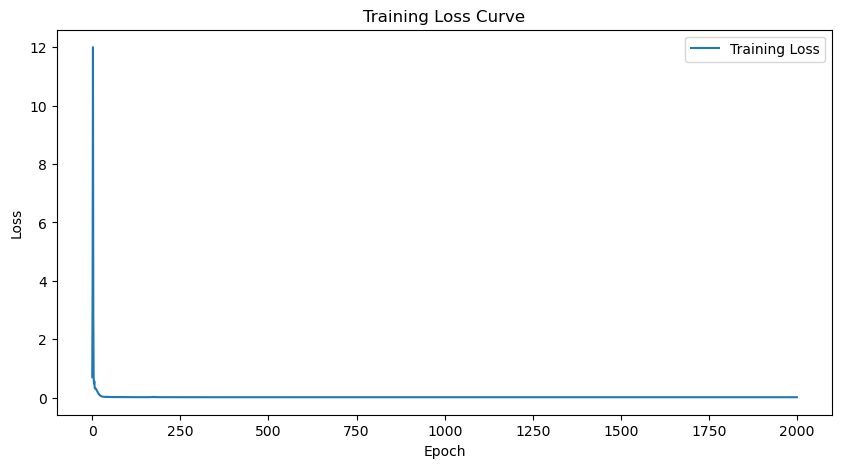

Final Model Accuracy: 70.79%
Final Model F1-score: 0.7299


In [ ]:
input_dim = X_train.shape[1]
hidden_dim = 256 
print(f"Training MLP model with input_dim={input_dim} and hidden_dim={hidden_dim}")

custom_mlp, losses, best_accuracy, best_f1 = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)

In [ ]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to '{filepath}'.")

save_checkpoint(custom_mlp, torch.optim.Adam(custom_mlp.parameters()), len(losses), losses[-1], checkpoint_file)

Checkpoint saved to '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_0_layer.pth'.


In [ ]:
y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
print(classification_report(y_test, y_pred_final, target_names=["infringement", "non_infringement"]))

                  precision    recall  f1-score   support

    infringement       0.77      0.61      0.68       194
non_infringement       0.67      0.81      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.71       380
    weighted avg       0.72      0.71      0.71       380



/tmp/ipykernel_2648723/2137335780.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()


In [ ]:
print(totaltime_non_infringement)
print(tpot_non_infringement)

print(totaltime_infringement)
print(tpot_infringement)

0.8163895791974561
0.0065553748931819955
0.875946436399295
0.006335278155685577
